Diego García Maroto (diegar20@ucm.com)

EXAMEN DE ANÁLISIS DE DATOS.

CURSO 2022/2023

CONVOCATORIA DE ENERO 2022

# Imports y funciones útiles

In [28]:
### IMPORTS ###
# Módulos básicos y otros
import numpy as np
import numpy.ma as ma
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.ticker as tick
import seaborn as sns
import pandas as pd

# Estadística
from scipy import stats 
from scipy import special
from scipy import signal
from scipy.fft import fft 
from scipy.fft import fft 
from statsmodels.tsa import stattools 
from scipy import signal
from scipy.stats.stats import pearsonr

# Cartografía 
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader

# Lectura de datos
from netCDF4 import Dataset
import xarray as xr

# Índices Climáticos
from xclim.core.calendar import percentile_doy
from xclim.indices import tn10p, tx10p

**Funciones de los cuadernos de clase:**

In [3]:
def region2(A,lonmin, lonmax, latmin, latmax):
    reg = np.nanmean(A[:,:,(lonpr>lonmin)&(lonpr<lonmax)][:,(latpr>latmin)&(latpr<latmax),:],axis=(1,2))
    n = reg.size
    mreg = np.nanmean(reg,axis=0)
    anom = reg.copy()*np.NaN
    for j in range(n):
            anom[j] = reg[j] - mreg
    return anom
def region(A,lon,lat,lonmin,lonmax,latmin,latmax):
    nt, nlat, nlon = A.shape
    #lonmin,lonmax,latmin,latmax = 260, 360, 10, 75
    AN = A[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:]
    lon_AN= lon[(lon>lonmin)&(lon<lonmax)]
    lat_AN=lat[(lat>latmin)&(lat<latmax)]
    return lat_AN, lon_AN, AN

In [4]:
def dibujo_1_mapa_cartopy(A,lon,lat,levs,cmap1,l1,titulo, ax,res='110m', cformat="%.2f"):
    im=ax.contourf(lon,lat,A
                   ,cmap=cmap1,levels=levs,extend='both',transform=ccrs.PlateCarree())
    ax.coastlines(linewidth=2,resolution=res);
    ax.set_title(titulo,fontsize=24)
    cbar = plt.colorbar(im, extend='neither', spacing='proportional',
                orientation='horizontal', shrink=0.6, format=cformat,ax=ax)
    cbar.set_label(l1, size=24)
    cbar.ax.tick_params(labelsize=16) 

# Esta función te sirve para dibujar en una misma figura dos mapas superpuestos, como podría ser
# el caso de un mapa A de regresion y un mapa B de correlacion significativa, del que solo te interesa
# las regiones donde es significativa la señal
def dibujo_2_mapas_cartopy_hatches(A,B,lon,lat, levs, cmap1, l1, t1):

    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(0))
    
    im = ax.contourf(lon,lat,A.reshape(len(lat),len(lon)), 
                     extend='both',cmap=cmap1,levels=levs,transform = ccrs.PlateCarree())

    ax.coastlines(linewidth=2); 
    fig.colorbar(im,ax=ax,label = l1) #Para la barra de colores
    im = ax.contourf(lon,lat,B.reshape(len(lat),len(lon))
                 ,extend='both'
                 ,hatches='.',cmap=cmap1,alfa=0,levels=levs,transform = ccrs.PlateCarree())
    #el uso de alfa=0 lo que hace es que solo salgan los puntos y no salgan los colors porque los pones totalmente transparentes
    ax.set_ylim(lat[-1], lat[0])
    ax.set_xlim(lon[0], lon[-1])

In [5]:
def anom(X,nyr,par):
    # si par = st, anomalías estandarizadas  
    ns,nt=np.shape(X) 
    nmes=int(nt/nyr)
    An=ma.empty([ns,nt])
    
    A = X.reshape(nyr,nmes,ns)
    mA = np.mean(A,axis=(0,1))

    An = A - mA
    
    if par == 'st':
        An = An/np.std(An,axis=(0,1))

    return An.reshape(ns,nyr*nmes)

# función pearsonr para y 2D, x 1D
def pearsonr_2D(y, x):
    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    rho = upper / lower
    return rho


# función para calcular correlaciones y regresiones
def IndexRegression(Data,Index,alfa,sig,pp):
    try:
        [ns,nt]=Data.shape # n1=espacio, n2=tiempo
    except ValueError:
        # si Data es un índice
        ns=1
        nt=len(Data)
        Data = np.array([Data])
        
    cor=ma.empty([ns,])
    Pvalue=ma.empty([ns,])
    reg=np.dot(Data,Index)/(nt-1)
    
    for nn in range(ns): 
        bb=pearsonr(Data[nn,:],Index) # Para cada punto del espacio hago la correlación
        cor[nn]=bb[0]
        Pvalue[nn]=bb[1]

    if sig == 'test-t':
        cor_sig=ma.masked_where(Pvalue>alfa,cor) # Enmascara los que tienen el Pvalue mayor que alpha
        reg_sig=ma.masked_where(Pvalue>alfa,reg)
        
    if sig == 'MonteCarlo':
        corp = ma.empty([ns,pp])
        for p in range(pp): #pp: número de permutaciones
            corp[:,p] = pearsonr_2D(Data,np.random.permutation(Index)) # Lo hago para una permutación aleatoria de los índices
            # aquí uso la función pearsonr_2D y me ahorro un bucle en ns
        
        for nn in range(ns): # Contamos cuantas veces no encontramos esa correlación de forma aleatoria 
            hcor = np.count_nonzero((cor[nn]>0)&(corp[nn,:]<cor[nn])|(cor[nn]<0)&(corp[nn,:]>cor[nn]))
            # nivel de confianza
            Pvalue[nn] = hcor/pp
            
        cor_sig = ma.masked_where(Pvalue<(1-alfa),cor)
        reg_sig = ma.masked_where(Pvalue<(1-alfa),reg)


    return cor,Pvalue,cor_sig,reg,reg_sig # Los que ponen sig llevan la mascara

In [6]:
# Esta función te proporciona anomalías ya sean estandarizadas o no, al introducir un campo con dimension (espacio,tiempo)
def anom2(X, nyr, par):
    # si par = st quiere decir que estandarizo. Si no, no (pongo, por ejemplo,'pp')
    ns, nt = np.shape(
        X)  # una de las dimensiones es tiempo, la segunda, y la otra puede ser el numero de modos, o de espacios..
    nmes = int(nt / (nyr));

    # dividimos el número de tiempos por el numero de años porque en caso de que queramos calcular
    # anomalias estacionales de una secuencia mensual (enero-media(diciembre-enero-febrero)) en lugar de una media estacional

    An = ma.empty([ns, nt])

    for i in range(ns):
        A = X[i, :].reshape(nyr, nmes)
        mA = np.mean(A)
        for j in range(0, nyr):
            A[j, :] = A[j, :] - mA

        if par == 'st':

            stdA = ma.empty([nmes, ])
            for k in range(nmes):
                stdA[k] = np.std(A[:, k])
                if stdA[k] != 0:
                    A[:, k] = A[:, k] / stdA[k]

        # se reorganizan los datos
        A = np.transpose(A.reshape(nyr * nmes, 1))
        An[i, :] = A;

    return An

#esta funcion calcula el coeficiente de correlacion de pearson en una matriz con 2 dimensiones

def region3(data,lat,lon,lonmin,lonmax,latmin,latmax):
    # data[t,lon,lat]
    latc=lat[(lat>=latmin)&(lat<=latmax)]
    lonc=lon[(lon>=lonmin)&(lon<=lonmax)]
    datac = data[:,:,(lon>=lonmin)&(lon<=lonmax)][:,(lat>=latmin)&(lat<=latmax),:]
    return datac,latc,lonc

# Esta función te quita o te pone los nan 

def quitonans(mat):
    out = mat[:,~np.isnan(mat.mean(axis = 0))]
    return out

def pongonans(matred,mat):
    out = mat.mean(axis = 0 )
    out[:] = np.nan
    out[~np.isnan(mat.mean(axis = 0))] = matred
    return out

def season(Z,e1,e2,nyrs):
#para que funcione los datos Z tienen que estar con dimensiones nyrs,12,ns
#e1 y e2 son los meses inicial y final de las estaciones
#e1=2;e2=4 ;esta='MAM';
#e1=5;e2=7 ;esta='JJA';
#e1=6;e2=8 ;esta='JAS';
#e1=8;e2=10 ;esta='SON';
#e1=11;e2=1 ;esta='DJF';
#e1=10;e2=1 ;esta='NDJF';
   
    if e1==11:
        Zs1= Z[:-1,e1,:]
        Zs2= Z[1:,:e2,:].mean(1)
        n1=1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    elif e1>e2:
        Zs1= Z[:-1,e1:11,:].mean(1)
        Zs2= Z[1:,:e2,:].mean(1)
        n1=12-e1
        n2=e2+1
        Zs=(Zs1*n1+Zs2*n2)/(n1+n2)
        nyrs=nyrs-1
    else:
        Zs = Z[:,e1:e2,:].mean(1)

    return Zs ,nyrs

In [7]:
# Esta función calcula correlaciones en datos de mas de una dimensión

def pearsonr_2D(y, x):
    upper = np.sum((x - np.mean(x)) * (y - np.mean(y, axis=1)[:,None]), axis=1)
    lower = np.sqrt(np.sum(np.power(x - np.mean(x), 2)) * np.sum(np.power(y - np.mean(y, axis=1)[:,None], 2), axis=1))
    rho = upper / lower
    return rho

# Esta función calcula mapas de Correlacion y Regresion a partir de un índice

def IndexRegrCorr(Data,Index,alfa,sig,pp):
    try:
        [ns,nt]=Data.shape # n1=espacio, n2=tiempo
    except ValueError:
        # si Data es un índice
        ns=1
        nt=len(Data)
        Data = np.array([Data])
        
    cor=ma.empty([ns,])
    Pvalue=ma.empty([ns,])
    reg=np.dot(Data,Index)/(nt-1)
    
    for nn in range(ns): 
        bb=pearsonr(Data[nn,:],Index) 
        cor[nn]=bb[0]
        Pvalue[nn]=bb[1]

    if sig == 'test-t':
        cor_sig=ma.masked_where(Pvalue>alfa,cor)
        reg_sig=ma.masked_where(Pvalue>alfa,reg)
        
    if sig == 'MonteCarlo':
        corp = ma.empty([ns,pp])
        for p in range(pp):
            corp[:,p] = pearsonr_2D(Data,np.random.permutation(Index))
            # aquí uso la función pearsonr_2D y me ahorro un bucle en ns
        
        for nn in range(ns): 
            hcor = np.count_nonzero((cor[nn]>0)&(corp[nn,:]<cor[nn])|(cor[nn]<0)&(corp[nn,:]>cor[nn]))
            # nivel de confianza
            Pvalue[nn] = hcor/pp
            
        cor_sig = ma.masked_where(Pvalue<(1-alfa),cor)
        reg_sig = ma.masked_where(Pvalue<(1-alfa),reg)
        
    return cor,Pvalue,cor_sig,reg,reg_sig

# Esta función calcula las EOFS

def eof(y, nm, alfa,test,perm):
    # Y es el campo
    # alfa es el nivel de significacion. Por ejemplo alfa=0.01 quiere decir un nivel de confianza del 99%\n",
    # nm es el numero de modos y nmes es simplemente si por cada año tenemos un dato medio (media de DEF) o el dato
    # intraestacional (diciembre, enero y febrero por separado).Normalmente nmes es 1
    # en test has de poner o 'Montecarlo' o 't-test'
    #tambien has de poner el numero de permutaciones, por ejemplo 100
    y2 =np.transpose(quitonans(np.transpose(y) ))
    ny, nt = y.shape
    ny2,nt=y2.shape
    # first you calculate the covariance matrix
    C = np.dot(y2,np.transpose(y2))
    R, d, R = linalg.svd(C)
    fvar = d / np.sum(d)
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(fvar[:nm], color='Blue', marker='o', label='Evolucion de autovalores')
    plt.legend()
    plt.grid()
    # Y había que transponerla si originariamente era (espacio, tiempo), pero ATN_e es (tiempo, espacio) así
    # que no se transpone. Aqui uso toda la matriz 
    PC = np.dot(np.transpose(y2), R[:, :nm+1])
    print(PC.shape)
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(PC[:,0], color='Blue', marker='o', label='PC1')
    plt.legend()
    plt.grid()
    # calculamos las anomalías estandarizadas
    # estandarizo la Pc
    PCs=(PC-np.mean(PC,0))/np.std(PC)

    Cor = ma.empty([ny, nm]);
    pvalCor = ma.empty([ny, nm]);
    Cor_sig = ma.empty([ny, nm]);
    Reg = ma.empty([ny, nm]);
    Reg_sig = ma.empty([ny, nm])
    #Aqui uso la que tienen nan porque ya no me va a dar problemas, pero le pongo numeros
    y=np.nan_to_num(y,nan=-999)

    for i in range(nm):
        Cor[:, i], pvalCor[:, i], Cor_sig[:, i], Reg[:, i], Reg_sig[:, i] = IndexRegrCorr(y, np.transpose(PCs[:,i]), alfa,test,perm)

    return Cor, Cor_sig, Reg, Reg_sig, PCs, fvar




In [8]:
def regresLinSim(x,y):
    alpha = 0.05
    x = np.squeeze(np.array(x))
    y = np.squeeze(np.array(y))
    N = x.size
    xm = x.mean()
    ym = y.mean()
    SXY = np.sum(x * y) - N * xm * ym
    SXX = np.sum(x * x) - N * xm * xm
    SYY = np.sum(y * y) - N * ym * ym
    SSR = SXY ** 2 / SXX 
    a1 = SXY / SXX
    a0 = ym - xm * a1
    yhat =  a0 + a1 * x
    e = y - yhat
    R2 = SSR / SYY
    SSE = SYY - SSR
    rho = SXY / np.sqrt(SXX*SYY)
    Se = np.sqrt( SSE / (N - 2 ) )
    t = stats.t.ppf(1-alpha/2,N-2)
    IC_a1 = a1 + np.array([-1, 1]) * t * Se / np.sqrt(SXX)
    IC_a0 = a0 + np.array([-1, 1]) * t * Se * np.sqrt(np.sum(x*x)/N/SXX)
    xvec = np.linspace(x.min(),x.max(),100)
    muY = ym + a1 * (xvec - xm) 
    AmuY = t * Se * np.sqrt(1/N + (xvec-xm) * (xvec -xm) /SXX)
    AY = t * Se * np.sqrt( 1 + 1/N + (xvec-xm) * (xvec -xm) /SXX)
    fig,ax = plt.subplots(1,2,figsize=(18,8))
    ax[0].plot(x,y,'o',markeredgecolor='black',markeredgewidth=1)
    #ax[0].grid()
    ax[0].plot(xvec,muY+AmuY,color='orange')
    ax[0].plot(xvec,muY-AmuY,color='orange')
    ax[0].plot([x.min(), x.max()],[a0+a1*x.min(), a0+a1*x.max()],'r')
    ax[0].plot(xvec,muY+AY,color='k')
    ax[0].plot(xvec,muY-AY,color='k')
    ax[0].set_title('Simple Linear Regression')
    ax[0].set_ylabel('y')
    ax[0].set_xlabel('x')
    ax[0].text(0.5,0.05,r'$a_0$=[%.3f,%.3f]''\n'r'$a_1$=[%.3f,%.3f]''\n'r'$\rho =$ %.2f'%(IC_a0[0],IC_a0[1],IC_a1[0],IC_a1[1],rho), 
                transform=ax[0].transAxes,size=11,bbox=dict(boxstyle='round', facecolor='w', alpha=0.7))
    #ax[0].text(0.5,0.1,'a1=[%.3f,%.3f]'%(IC_a1[0],IC_a1[1]), transform=ax[0].transAxes)
    #ax[0].text(0.5,0.15,'rho=%.2f'%(rho), transform=ax[0].transAxes)
    ax[1].plot(yhat,e/Se,'o',markeredgecolor='black',markeredgewidth=1)
    #ax[1].grid()
    ax[1].set_xlabel(r'$\hat{y}$')
    ax[1].set_ylabel(r'$\hat{e}/\sigma_E$')
    ax[1].set_title('Standardized residuals')
    return ax, a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY

In [335]:
# Funciones definidas en la libreta de clase
def runningMean(x,T):
    y = x.copy() * np.NaN
    N = x.size
    ini = int((T-1)/2)
    fin = int(T/2)
    for i in range(ini,N-fin):
        y[i] = np.mean(x[i-ini:i+fin+1])
    return y


def espectroArmonico(x,At):
    x = np.squeeze(np.array(x))
    N = x.size 
    xm = x.mean()
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    jvec=np.arange(1,N+1)
    a = np.zeros(Nmax)
    b = np.zeros(Nmax)
    xa = x-xm
    fac = 2*np.pi*jvec/N
    for k in range(Nmax):
        a[k] = 2 / N * np.sum( np.matmul(xa,np.cos(fac*(k+1)) ))
        b[k] = 2 / N * np.sum( np.matmul(xa,np.sin(fac*(k+1)) ))
    if (N%2)==0: b[Nmax-1]=0
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( a**2+b**2 ) / 2
    f = kvec/(N*At)
    return f,G

def espectroFFT(x,At):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( ap**2+bp**2 ) / 2
    f = kvec/(N*At)
    return f,G

def redSpectra(a,s2):
    f = np.arange(.0,.51,.01)
    N = f.size
    G = (s2*(1-a**2))/(1+a**2-2*a*np.cos(2*np.pi*f))
    #Hay que multiplicar por 2 porque sólo sacamos la parte positiva
    return f,2*G

def ajusteArmonico(x,numArm):
    x = np.squeeze(np.array(x))
    N = x.size 
    xm = x.mean()
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    jvec=np.arange(1,N+1)
    a = np.zeros(Nmax)
    b = np.zeros(Nmax)
    xa = x-xm
    fac = 2*np.pi*jvec/N
    for k in range(Nmax):
        a[k] = 2 / N * np.sum( np.matmul(xa,np.cos(fac*(k+1)) ))
        b[k] = 2 / N * np.sum( np.matmul(xa,np.sin(fac*(k+1)) ))
    if (N%2)==0: b[Nmax-1]=0
    kvec = np.arange(1,Nmax+1)
    xhat = np.zeros(N)
    n = np.min([numArm,Nmax])
    for j in range(N):
        xhat[j] =  xm + np.sum( a[:n] * np.cos (2*np.pi*kvec[:n]*(j+1)/N) + b[:n] *
                               np.sin (2*np.pi*kvec[:n]*(j+1)/N) )
    return xhat,a,b

def ajusteArmonicoFFT(x,numArm):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    xhat = np.zeros(N)
    n = np.min([numArm+1,Nmax])
    for j in range(N):
        xhat[j] =  xm + np.sum( ap[:n] * np.cos (2*np.pi*kvec[:n]*(j)/N) + bp[:n] * 
                               np.sin (2*np.pi*kvec[:n]*(j)/N) )
    return xhat,ap,bp

def calculoAR1(x):
    xm = np.mean(x)
    N = x.size
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    sx = np.std(x, ddof=1)
    fac = np.sqrt((N-1)/(N-2)*(1-a**2))*sx
    AR1 = x * np.NaN
    rng = np.random.default_rng()
    Z = rng.normal(0,1,N)
    #También podéis generar el ruido blanco con stats de scipy
    #Z = stats.norm.rvs(size=N)
    AR1[0] = Z[0]
    for i in range(N-1):
        AR1[i+1] =  a * ( AR1[i] ) + fac * Z[i+1]
    return AR1 + xm


def calculoAutocov(x,nlag):
    cov = np.zeros([nlag+1])
    N = x.size
    xm = np.mean(x)
    ax = x-xm
    for t in range(nlag+1):
        cov[t] = np.sum(ax[:N-t]*ax[t:])/(N-1)
    return cov

def region(sst,lonmin, lonmax, latmin, latmax):
    reg = sst[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:].mean(axis=(1,2))
    nt = reg.size
    nm = 12
    ny = int(nt/nm)
    reg = reg.reshape(nm,ny,order='F')
    mreg = np.nanmean(reg,axis=1)
    anom = reg.copy()*np.NaN
    for i in range(ny):
        for j in range(nm):
            anom[j,i] = reg[j,i] - mreg[j]
    return anom

In [574]:
def nor(mu,sigma,x):
    #Nota: también podrías usar la función norm.pdf(x,k) del módulo stats del paquete scipy
    N=1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))
    return N

def GEV(x,c):
    #Función que calcula la función densidad de probabilidad de Generalized Extrem Value normalizada
    # con m = 0, s = 1
    #nota: también puedes usar g=stats.genextreme.pdf(x,-c)
    if ( abs(c) < 0.005 ) :
        g = np.exp(-np.exp(-x))*np.exp(-x)
    else:
        g = ( np.power( 1 + c * x , -1-1/c) ) * np.exp( - np.power(1 + c * x ,-1/c) )
    return g

def GEVms(x,c,m,s):
    #Función que calcula la función de densidad de probabilidad Generalizada Extreme Value sin normalizar
    y = ( x - m ) / s
    if ( abs(c) < 0.005 ) :
        g = ( np.exp(-np.exp(-y))*np.exp(-y) ) / s
    else:
        g = ( np.power( 1 + c * y , -1-1/c) ) * np.exp( - np.power(1 + c * y ,-1/c) ) / s
    return g

def GPDs(y,c,s):
    #Función que calcula la función de densidad de probabilidad de Pareto Generalizada 
    if (abs(c)<0.0001):
        h = np.exp(-y/s)*(1/s)
    else:
        h = (1/s) * ( 1 + c * y / s) ** (-1-1/c)
    h[y<=0]=0
    return h

def MLE_GEV(c,m,s,x):
    #Función que calcula la función likelihood sobre GEV con 
    #los parámetros de entrada c,m,s
    #y la muestra de datos x
    if ( (s < 0) | np.any(1 + c * (x-m)/s ) < 0):
        sal=1e7
    else:            
        if (abs(c) > 0.00001 ):
            t = (1 + c * (x-m)/s )**(-1/c)
        else :
            t = np.exp(-(x-m)/s)
        f = - np.log(s) + (c +1)*np.log(t) -t
        sal = f.sum()
    return -sal


def returnLevel(p, c,m,s):
    if (abs(c) > 0.00001 ):
        zp = m - ( s / c ) * ( 1 - ( - np.log( 1 - p ) ) ** ( - c ))
    else :
        zp = m - s * np.log( - np.log( 1 - p ) )
    return zp


def densityPlotGEV(ax,x,c,m,s):
    n, bins, dummy = ax.hist(x,density=True,label='Empírica')
    x1, x2 = 2*bins[0] - bins[1], 2* bins[-1] - bins[-2]
    ax.set_xlim(x1,x2)
    x_x = np.linspace(x1,x2,200)
    y_y = GEVms(x_x,c,m,s)
    ax.plot(x_x,y_y,'r',label='Ajuste')
    ax.legend()
    #ax.grid()
    ax.set_ylabel('Probabilidad f(z)')
    ax.set_xlabel('z')
    ax.set_title('Densidad de probabilidad')
    return

def probabilityPlot(ax,pExp,pTeor):
    ax.plot([0,1],[0,1])
    ax.plot(pExp,pTeor,'o')
    ax.set_ylabel('Modelo')
    ax.set_xlabel('Empírico')
    ax.set_title('Gráfico de probabilidad')
    #ax.grid()
    return

def quantilePlot(ax,xTeor,xSort):
    ax.plot([xSort[0],xSort[-1]],[xSort[0],xSort[-1]])
    ax.plot(xTeor,xSort,'o')
    ax.set_ylabel('Modelo')
    ax.set_xlabel('Empírico')
    ax.set_title('Gráfico de cuantiles')
    #ax.grid()
    return

def returnPlot(ax,p,zp,pExp,xSort):
    ax.semilogx(1/p,zp)
    #ax.grid()
    ax.set_xlim(1e-1,1e6)
    ax.semilogx(1/pExp,xSort,'o')
    ax.set_title('Gráfico de valores de retorno')
    ax.set_xlabel('Periodo de retorno (años)')
    ax.set_ylabel('Valor de retorno')
    return
    
def diagnosticsGEV(x,c,m,s):
    y = (x-m)/s
    ySort = np.sort(y)
    pExp = np.arange(1,ySort.size+1,1)/(ySort.size+1)
    pTeor = stats.genextreme.cdf(ySort,-c)
    xSort = np.sort(x)
    pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
    pExpinv = np.arange(xSort.size+1,1,-1)/(xSort.size+1)
    xTeor = returnLevel(1-pExp, c,m,s)    
    p = np.logspace(-6, -1e-2, 100)
    zp=returnLevel(p,c,m,s)
    fig, ax = plt.subplots(2, 2, figsize=(14,10))
    probabilityPlot(ax[0,0],pExp,pTeor)
    quantilePlot(ax[0,1],xTeor,xSort)
    returnPlot(ax[1,0],p,zp,pExpinv,xSort)
    densityPlotGEV(ax[1,1],x,c,m,s)
    fig.suptitle('Diagnostico',weight='bold',fontsize=24)
    plt.tight_layout()
    return fig, ax

def diagnosticsGPD(x,c,m,s,numYears):
    fig, ax = plt.subplots(2, 2, figsize=(14,10))
    fig.suptitle('Diagnostics',weight='bold',fontsize=18)
    xSort = np.sort(x)
    pExp = np.arange(1,xSort.size+1,1)/(xSort.size+1)
    pExpinv = np.arange(xSort.size+1,1,-1)/(xSort.size+1)
    rv = stats.genpareto(c,m,s)
    pTeor = rv.cdf(xSort)
    xTeor = rv.ppf(pExp)
    fac = x.size / numYears
    p = np.logspace(-4, 2 , 100)
    zp = rv.ppf(1-p)
    fac = x.size / numYears
    returnPlot(ax[1,0],p*fac,zp,pExpinv*fac,xSort)
    probabilityPlot(ax[0,0],pExp,pTeor)
    quantilePlot(ax[0,1],xTeor,xSort)
    densityPlotGPD(ax[1,1],x,c,m,s)
    plt.tight_layout()
    return

def densityPlotGPD(ax,x,c,m,s):
    n, bins, dummy = ax.hist(x,density=True,label='Empirica')
    x1, x2 = 2*bins[0] - bins[1], 2* bins[-1] - bins[-2]
    ax.set_xlim(x1,x2)
    x_x = np.linspace(x1,x2,200)
    y_y = stats.genpareto.pdf(x_x,c,m,s)
    ax.plot(x_x,y_y,'r',linewidth = 4, label='Ajuste')
    ax.legend()
    ax.grid()
    ax.set_ylabel('probabilidad h(x)')
    ax.set_xlabel('x')
    return


**Otras funciones:**

In [9]:
# Algunas funciones de https://docs.xarray.dev/en/v0.9.2/examples/monthly-means.html
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

def resample_month_to_season(ds):
    ''' Función para pasar de una serie mensual a una serie estacional'''
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='standard'),
        coords=[ds.time],name='month_length')

    # Primero lo paso de vuelta a número de días
    result = ((ds * month_length/100).resample(time='QS-DEC').sum() / 
            month_length.resample(time='QS-DEC').sum())*100 # Hay que dividir entre los días de cada estación 
    return result


In [10]:
from matplotlib import style

def series_style():
    ''' Hago una función para poner los ajustes que quiero usar para todas las gráficas que no sean mapas '''
    plt.style.use('seaborn') # Estilo general

    font = {'size'   : 14}
    plt.rc('font', **font) # Tamaño generico de fuentes
    parameters = {'xtick.labelsize':14,
                'ytick.labelsize':14,
                'axes.labelsize':14,
                'axes.labelweight':'bold',
                'axes.titleweight':'bold',
                'axes.titlesize':18,
                'legend.fontsize':15,
                'legend.frameon':True,
                'legend.facecolor':'w',
                'legend.title_fontsize':16,
                'ytick.major.size': 3.5,
                'ytick.major.width': 0.8,
                'xtick.major.size': 3.5,
                'xtick.major.width': 0.8,  
                'axes.linewidth':1,
                'axes.edgecolor':'grey',
                'xtick.color':'grey',
                'xtick.labelcolor':'k',
                'ytick.color':'grey',
                'ytick.labelcolor':'k'}
    plt.rcParams.update(parameters)
series_style()

In [422]:
cus = sns.color_palette("ch:start=0.2,rot=-0.2,dark=0.6, light=.9",12)
def climograma(df,start_year,end_year,var_name,save=False,violin = False, outliers = True, figname='barajas',fuente='',palette=cus,suptitle='Ciclo estacional',ylabel='Temperatura (ºC)'):
    ''' 
    Función para realizar boxplots del ciclo estacional a partir de unos datos de temperatura a 2m.

    Entradas:
    - df: DataFrame con los datos de temperatura, extructurado por columnas de 'day','month','year','temp'
    - start_year: año de inicio del periodo que queremos representar 
    - end_year: año de fin del periodo que queremos representar 
    - save: si se quiere guardar la figura poner save=1
    - violin: si se quiere represnetar un diagrama de violines poner violin=1
    - outliers: si se quieren quitar los outliers del boxplot poner outliers=0
    - figname: nombre para el png si se pide guardar 'figname'+'.png'
    - fuente: str con el nombre de la fuente de los datos 
    - palette: paleta de colores que se quiere usar

    Salidas:
    - Tupla con la figura (fig) y el axis (ax) donde se representa el plot.
    
    '''
    df = df[(start_year <= df['year'])&(df['year'] <= end_year)]    # Selecciono los años
    means = df.groupby(['month'],dropna=True).mean(var_name)          # Media de cada mes para representar encima    
    fig, ax = plt.subplots(figsize=(12,8))
    meses = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic'] # Nombres de los meses para los xtick
    if violin == True: # Si queremos representarlo como violines
        sns.violinplot(data=df, x='month', y=var_name, ax=ax, showfliers = False)
    else: 
        if outliers == True: # Boxplot con outliers 
            sns.boxplot(data=df, x='month', y=var_name, ax=ax,zorder=2,palette=palette) #,whis=2)
            
        else: # Boxplot sin outliers 
            sns.boxplot(data=df, x='month', y=var_name, ax=ax, showfliers = False,boxprops=dict(alpha=.7,zorder= 2),zorder=2)


    # Plot de la línea de medias
    ax.plot(np.arange(12), means[var_name],linewidth=5, color ='r',zorder=3, alpha=0.5, label='Media mesual')
    # Ajustes del ax
    ax.set_ylabel(ylabel, size=15 , fontweight = 'bold')
    ax.set_xlabel('Meses', size=15, fontweight = 'bold')
    ax.set_xticks(np.arange(12),meses,size=14) # Para cambiar las etiquetas a los nombres de meses
    ax.yaxis.set_tick_params(labelsize=14)
    ax.legend(prop={'size':14})

    mid = (fig.subplotpars.right + fig.subplotpars.left)/2 # Para alinear el title y el suptitle
    plt.suptitle(suptitle,size=32, x=mid)
    plt.title(u'Fuente: %s; Periodo: %i-%i'%(fuente,start_year,end_year), size=18)
    plt.tight_layout()
    if save == True:  # Si queremos guardar la figura
        fig.savefig(figname+'.png',dpi=500,facecolor='w')
        
    return fig, ax

In [402]:
def histogram_plotter_with_normal_estimation(data:pd.DataFrame,variable:str,variable_name:str,title:str, verbose:bool=True, color:str='pink') -> None:
    """
    description:
    --------------------------------------
    
    arguments:
        - data: entry dataframe
        - variable: name of the variable of study
        - title: plot title
        - verbose: True if you want the stats asociated with the variable
    """
    mean= np.mean(data[variable])
    std= np.std(data[variable], ddof = 1)
    n= np.shape(data[variable])[0]
    bins= np.arange(np.min(data[variable]),np.max(data[variable]),step=(np.max(data[variable])-np.min(data[variable]))/30)
    fig,ax= plt.subplots()
    sns.histplot(data, x=variable,bins=bins,stat='density',color=color)
    normal_distribution= stats.norm.pdf(bins,mean,std)
    plt.plot(bins,normal_distribution,'k',label='Teórico')
    plt.legend(loc='best')
    plt.xlabel(variable_name)
    plt.ylabel('Densidad')
    plt.title(title)
    quantile_data= np.quantile(data[variable],(0.05,0.95))
    quantile_theoric= [stats.norm.ppf(0.05,mean,std),stats.norm.ppf(0.95,mean,std)]
    if verbose:
        print('Los percentiles para los datos son: q(5%%)=%.2f and q(95%%)= %.2f' %(quantile_data[0],quantile_data[1]))
        print('Los percentiles teóricos para los datos son: q(5%%)=%.2f and q(95%%)= %.2f' %(quantile_theoric[0],quantile_theoric[1]))
        alfa=0.05
        #We must use the t-student distribution, beacuse with don't now the standard deviation of the data
        t_alpha_2= stats.norm.ppf(1-alfa/2,loc=0,scale=std/np.sqrt(n))
        ic= t_alpha_2
        print('\nMedia: ',np.round(mean,2))
        print('Índice de Confianza del 95% para la media: '+str(np.round(mean,2))+'+-'+str(np.round(ic,2)))
        ic_scipy=stats.norm.interval(alpha=0.95,loc=mean,scale=std/np.sqrt(n))#,df=n-1)
        print('Con la función de scipy (ic1,ic2): ('+str(np.round(ic_scipy[0],2))+','+str(np.round(ic_scipy[1],2))+')')
        
        #Ahora la varianza
        varianza=np.var(data[variable])
        chi2_alpha_2=stats.chi2.ppf(1-alfa/2,n-1)
        chi2_1_alpha_2=stats.chi2.ppf(alfa/2,n-1)
        ic1 = (n-1)*np.var(data[variable])/chi2_alpha_2
        ic2 = (n-1)*np.var(data[variable])/chi2_1_alpha_2
        print('\nVarianza: ', np.round(varianza,2))
        print('Índice de Confianza del 95% para la varianza (ic1,ic2): ('+str(np.round(ic1,2))+','+str(np.round(ic2,2))+')')
        scipy_ic_std = stats.chi2.interval(alpha=0.95,df=n-1,loc=0,scale=1)
        ic1_var=(n-1)*np.var(data[variable])/scipy_ic_std[1]
        ic2_var=(n-1)*np.var(data[variable])/scipy_ic_std[0]
        print('Con la función de scipy (ic1,ic2): ('+str(np.round(ic1_var,2))+','+str(np.round(ic2_var,2))+')')

        #Podemos calcular también otros momentos centrales, como asimetría y curtosis de nuestra muestra
        asimetria=stats.skew(data[variable])
        kutosis=stats.kurtosis(data[variable])
        print('\nLa asimetría es '+str(np.round(asimetria,2))+' y el valor teórico ',stats.norm.stats(loc=mean,scale=std,moments='s'))
        print('La curtosis es '+str(np.round(kutosis,2))+' y el valor teórico ',stats.norm.stats(loc=mean,scale=std,moments='k'))

    return fig,ax,mean,ic_scipy,std

---

# 1. Estadística Básica

## Análisis estadístico de las temperaturas 

Leo los datos de temperatura de STEAD:

In [409]:
path = '../Practica 2/data/'
file_max = 'tmax_pen.nc'
data_max = xr.open_dataset(path+file_max)
file_min = 'tmin_pen.nc'
data_min = xr.open_dataset(path+file_min)

# Separamos las variables (las lat y lon son las mismas al ser la misma base de datos)
lon = data_min.lon
lat = data_min.lat

# Selecciono el periodo de referencia que usaremos para el estudio
tmin = data_min.tn.sel(Time=slice('1960','2010'))
tmax = data_max.tx.sel(Time=slice('1960','2010'))

# Cambio el nombre del tiempo
tmin = tmin.rename({'Time': 'time'})
tmax = tmax.rename({'Time': 'time'})
display(tmax)
display(tmin)

<xarray.DataArray 'tx' (time: 18628, lat: 190, lon: 230)>
[814043600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * time     (time) datetime64[ns] 1960-01-01 1960-01-02 ... 2010-12-31
Attributes:
    units:      Celsius degrees
    long_name:  Maximum temperature

<xarray.DataArray 'tn' (time: 18628, lat: 190, lon: 230)>
[814043600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * time     (time) datetime64[ns] 1960-01-01 1960-01-02 ... 2010-12-31
Attributes:
    units:      Celsius degrees
    long_name:  Minimum temperature

### Ciclo estacional

Representaré el boxplot de la media de las temperaturas máximas en España:

In [45]:
# Medias en el espacio
tmax_time = tmax.mean(dim=['lat','lon'])

In [ ]:
tmin_time = tmin.mean(dim=['lat','lon'])

In [46]:
# Paso a dataframe para poder usar la función de boxplot
df_tmax = tmax_time.to_dataframe()
df_tmax['day'] = df_tmax.index.day
df_tmax['month'] = df_tmax.index.month
df_tmax['year'] = df_tmax.index.year

df_tmin = tmin_time.to_dataframe()
df_tmin['day'] = df_tmin.index.day
df_tmin['month'] = df_tmin.index.month
df_tmin['year'] = df_tmin.index.year

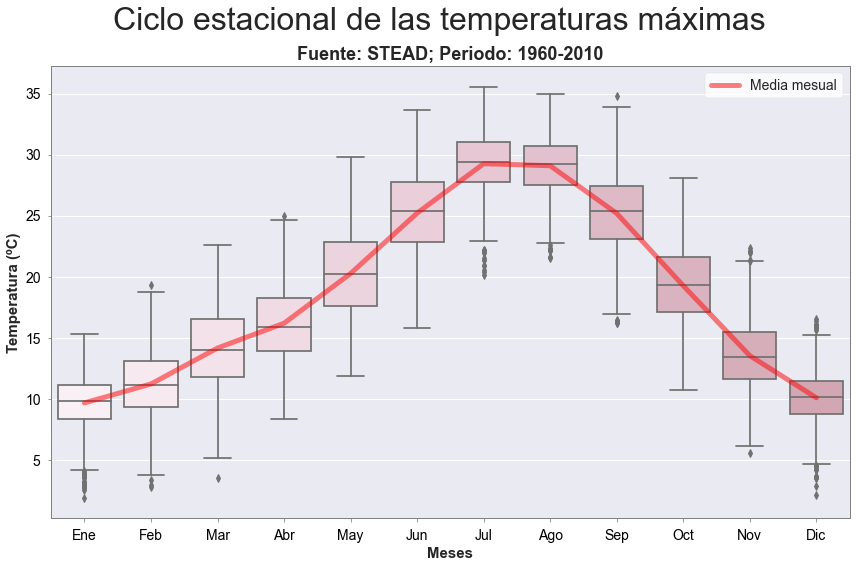

In [602]:
fig, ax = climograma(df_tmax,1960,2010,'tx', fuente='STEAD',save=True,figname='tmax_boxplot',
            suptitle='Ciclo estacional de las temperaturas máximas',palette=sns.color_palette("ch:start=1.2,rot=-0.2,dark=0.7, light=.95",12))


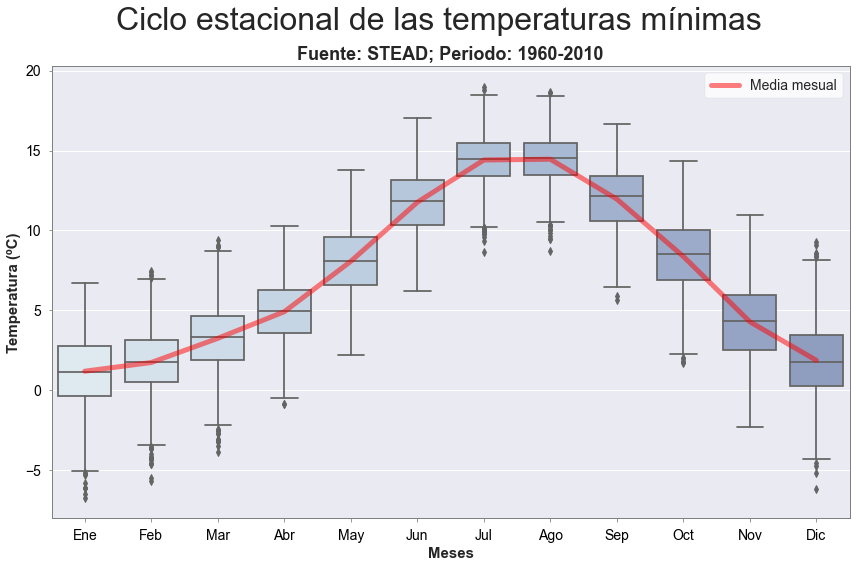

In [47]:
fig, ax = climograma(df_tmin,1960,2010,'tn', fuente='STEAD',save=True,figname='tmax_boxplot',
            suptitle='Ciclo estacional de las temperaturas mínimas')

### Distribución espacial (julio)

In [12]:
# Selección de julio
tmax7 = tmax.sel(time=tmax.time.dt.month==7)
tmin7 = tmin.sel(time=tmin.time.dt.month==7)
tmin7

<xarray.DataArray 'tn' (time: 1581, lat: 190, lon: 230)>
[69089700 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * time     (time) datetime64[ns] 1960-07-01 1960-07-02 ... 2010-07-31
Attributes:
    units:      Celsius degrees
    long_name:  Minimum temperature

#### De la media y percentiles:

In [13]:
# Media 
mtx = tmax7.mean('time')
mtn = tmin7.mean('time')

In [67]:
# Percentiles 90 y 10
p90tx = tmax7.quantile(0.95,dim='time')
p90tn = tmin7.quantile(0.95,dim='time')
p10tx = tmax7.quantile(0.05,dim='time')
p10tn = tmin7.quantile(0.05,dim='time')

c:\Users\digar7\anaconda3\envs\env1\lib\site-packages\numpy\lib\nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [170]:
p90tx.mean()

<xarray.DataArray 'tx' ()>
array(33.83345741)
Coordinates:
    quantile  float64 0.95

In [69]:
#fig.savefig('mapas_percentile5.png',dpi=250)

#### De la varianza

In [223]:
# Media 
stdtx = tmax7.std('time')
stdtn = tmin7.std('time')

Text(0.5, 0.98, 'Temperaturas diarias de julio (1960-2010)')

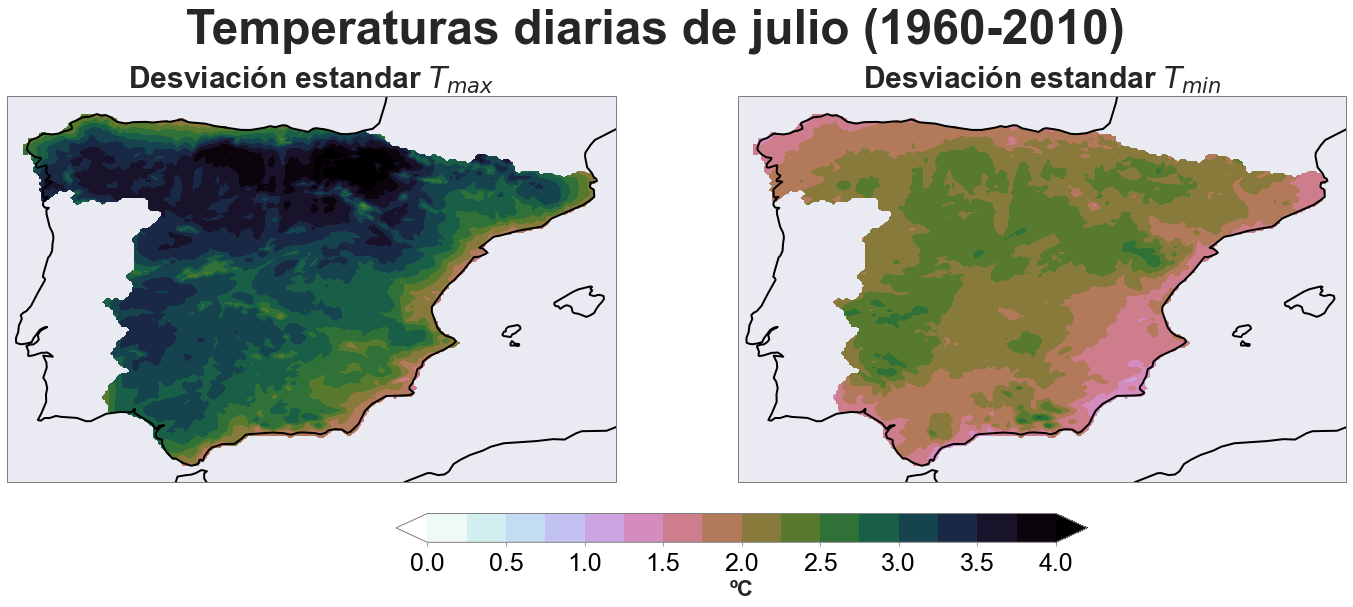

In [232]:

fig, ax = plt.subplots(1,2,figsize=(24,8),facecolor='w', subplot_kw={'projection': ccrs.PlateCarree(0)}) 
ax=ax.ravel().tolist()
step = 0.25
levels = np.arange(0,4+step,step)
var_list = [stdtx,stdtn]
titulos = [r'Desviación estandar $T_{max}$', r'Desviación estandar $T_{min}$']
for i in range(2):

    var = var_list[i]
    im=ax[i].contourf(lon,lat,var,cmap='cubehelix_r',levels=levels,extend='both',transform=ccrs.PlateCarree())
    ax[i].coastlines(linewidth=2,resolution='50m')
    ax[i].set_title(titulos[i],fontsize=30)

plt.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.35, 0.05, 0.4, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal',shrink=0.6)
cbar.set_label('ºC', size=22)
cbar.ax.tick_params(labelsize=25) 
fig.suptitle(u'Temperaturas diarias de julio (1960-2010)',size= 48, fontweight='bold')


### Histogramas e intervalos de confianza

In [172]:
# Consideramos el mes de julio (medias diarias)
df_tmax7 = df_tmax[df_tmax['month']==7]
df_tmin7 = df_tmin[df_tmin['month']==7]

# También las medias mensuales (un dato por mes)
df_tmax7m = df_tmax7.groupby('year').mean('year')
df_tmin7m = df_tmin7.groupby('year').mean('year')


Los percentiles para los datos son: q(5%)=25.06 and q(95%)= 32.92
Los percentiles teóricos para los datos son: q(5%)=25.28 and q(95%)= 33.26

Media:  29.27
Índice de Confianza del 95% para la media: 29.27+-0.12
Con la función de scipy (ic1,ic2): (29.15,29.39)

Varianza:  5.87
Índice de Confianza del 95% para la varianza (ic1,ic2): (5.48,6.3)
Con la función de scipy (ic1,ic2): (5.48,6.3)

La asimetría es -0.46 y el valor teórico  0.0
La curtosis es 0.23 y el valor teórico  0.0


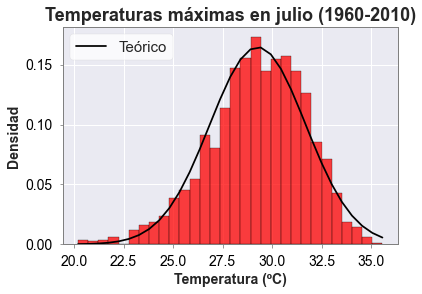

In [173]:
fig,ax,mean,ic_scipy,std = histogram_plotter_with_normal_estimation(df_tmax7,'tx','Temperatura (ºC)','Temperaturas máximas en julio (1960-2010)',color='red')
vline = ax.axvline(mean,color='b',linestyle=':',label='Media')


Los percentiles para los datos son: q(5%)=27.99 and q(95%)= 31.10
Los percentiles teóricos para los datos son: q(5%)=27.33 and q(95%)= 31.21

Media:  29.27
Índice de Confianza del 95% para la media: 29.27+-0.32
Con la función de scipy (ic1,ic2): (28.95,29.59)

Varianza:  1.37
Índice de Confianza del 95% para la varianza (ic1,ic2): (0.96,2.12)
Con la función de scipy (ic1,ic2): (0.96,2.12)

La asimetría es -0.49 y el valor teórico  0.0
La curtosis es 1.01 y el valor teórico  0.0


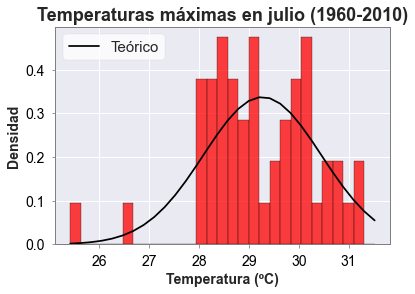

In [175]:
fig,ax,mean,ic_scipy,std = histogram_plotter_with_normal_estimation(df_tmax7m,'tx','Temperatura (ºC)','Temperaturas máximas en julio (1960-2010)',color='red')
vline = ax.axvline(mean,color='b',linestyle=':',label='Media')


Los percentiles para los datos son: q(5%)=11.73 and q(95%)= 16.83
Los percentiles teóricos para los datos son: q(5%)=11.83 and q(95%)= 17.00

Media:  14.42
Índice de Confianza del 95% para la media: 14.42+-0.08
Con la función de scipy (ic1,ic2): (14.34,14.49)

Varianza:  2.47
Índice de Confianza del 95% para la varianza (ic1,ic2): (2.3,2.65)
Con la función de scipy (ic1,ic2): (2.3,2.65)

La asimetría es -0.29 y el valor teórico  0.0
La curtosis es 0.07 y el valor teórico  0.0


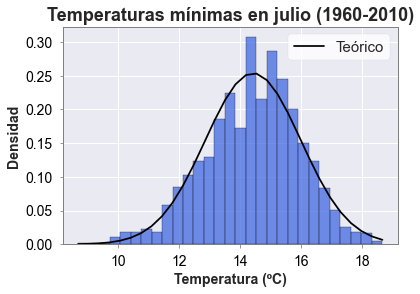

In [174]:
fig,ax,mean,ic_scipy,std = histogram_plotter_with_normal_estimation(df_tmin7,'tn','Temperatura (ºC)','Temperaturas mínimas en julio (1960-2010)',color='royalblue')
vline = ax.axvline(mean,color='b',linestyle=':',label='Media')


Los percentiles para los datos son: q(5%)=13.12 and q(95%)= 15.84
Los percentiles teóricos para los datos son: q(5%)=13.00 and q(95%)= 15.83

Media:  14.42
Índice de Confianza del 95% para la media: 14.42+-0.24
Con la función de scipy (ic1,ic2): (14.18,14.65)

Varianza:  0.73
Índice de Confianza del 95% para la varianza (ic1,ic2): (0.51,1.12)
Con la función de scipy (ic1,ic2): (0.51,1.12)

La asimetría es -0.4 y el valor teórico  0.0
La curtosis es 0.72 y el valor teórico  0.0


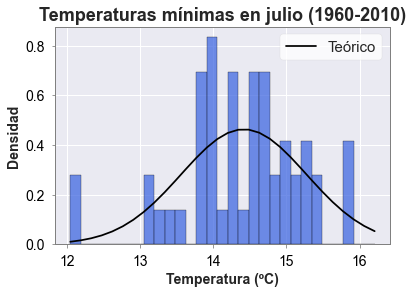

In [176]:
fig,ax,mean,ic_scipy,std = histogram_plotter_with_normal_estimation(df_tmin7m,'tn','Temperatura (ºC)','Temperaturas mínimas en julio (1960-2010)',color='royalblue')
vline = ax.axvline(mean,color='b',linestyle=':',label='Media')


Para comparar con los datos del informe de AEMet será util calcular la temperatura media:

In [158]:
# Dato del AEMet de julio 2022 para comparar (https://www.aemet.es/es/noticias/2022/08/avance_julio_2022)
media2022 = 25.6 # Julio 2022 (España penínsular)

In [159]:
tmean_time = (tmin_time+tmax_time)/2

In [177]:
# Paso a dataframe
df_tmean = tmean_time.to_dataframe(name='tm') # Hay que darle nombre a la variable nueva
df_tmean['day'] = df_tmean.index.day
df_tmean['month'] = df_tmean.index.month
df_tmean['year'] = df_tmean.index.year

# Consideramos el mes de julio (valores diarios)
df_tmean7 = df_tmean[df_tmean['month']==7]

# También las medias mensuales (un dato por mes)
df_tmean7m = df_tmean7.groupby('year').mean('year')

Los percentiles para los datos son: q(5%)=18.55 and q(95%)= 24.69
Los percentiles teóricos para los datos son: q(5%)=18.73 and q(95%)= 24.95

Media:  21.84
Índice de Confianza del 95% para la media: 21.84+-0.09
Con la función de scipy (ic1,ic2): (21.75,21.94)

Varianza:  3.58
Índice de Confianza del 95% para la varianza (ic1,ic2): (3.34,3.84)
Con la función de scipy (ic1,ic2): (3.34,3.84)

La asimetría es -0.36 y el valor teórico  0.0
La curtosis es 0.12 y el valor teórico  0.0


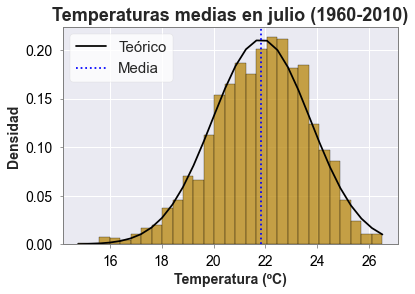

In [179]:
fig,ax,mean,ic_scipy,std = histogram_plotter_with_normal_estimation(df_tmean7,'tm','Temperatura (ºC)','Temperaturas medias en julio (1960-2010)',color='darkgoldenrod')
vline = ax.axvline(mean,color='b',linestyle=':',label='Media')
#vline2 = ax.axvline(media2022,color='r',linestyle='--',label='Julio 2022')
leg = ax.legend()

Los percentiles para los datos son: q(5%)=20.45 and q(95%)= 23.38
Los percentiles teóricos para los datos son: q(5%)=20.24 and q(95%)= 23.44

Media:  21.84
Índice de Confianza del 95% para la media: 21.84+-0.27
Con la función de scipy (ic1,ic2): (21.58,22.11)

Varianza:  0.92
Índice de Confianza del 95% para la varianza (ic1,ic2): (0.65,1.43)
Con la función de scipy (ic1,ic2): (0.65,1.43)

La asimetría es -0.41 y el valor teórico  0.0
La curtosis es 0.91 y el valor teórico  0.0


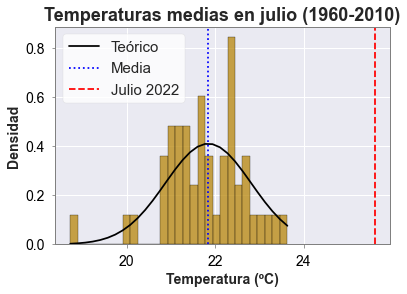

In [401]:
fig,ax,mean,ic_scipy,std = histogram_plotter_with_normal_estimation(df_tmean7m,'tm','Temperatura (ºC)','Temperaturas medias en julio (1960-2010)',color='darkgoldenrod')
vline = ax.axvline(mean,color='b',linestyle=':',label='Media')
vline2 = ax.axvline(media2022,color='r',linestyle='--',label='Julio 2022')
leg = ax.legend()

#### Evolución temporal de las medias de temperatura del mes

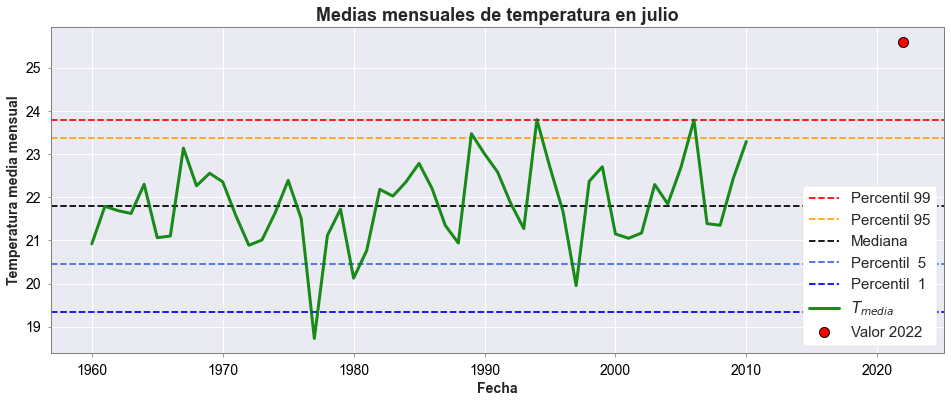

In [615]:
fig,ax = plt.subplots(figsize = (16,6),facecolor='w')

ax.axhline(df_tmean7m['tm'].quantile(0.99),color='red',linestyle='--',label='Percentil 99')
ax.axhline(df_tmean7m['tm'].quantile(0.95),color='orange',linestyle='--',label='Percentil 95')
ax.axhline(df_tmean7m['tm'].quantile(0.5),color='k',linestyle='--',label='Mediana')
ax.axhline(df_tmean7m['tm'].quantile(0.05),color='royalblue',linestyle='--',label='Percentil  5')
ax.axhline(df_tmean7m['tm'].quantile(0.01),color='b',linestyle='--',label='Percentil  1')


ax.plot(df_tmean7m.index,df_tmean7m['tm'],linewidth=3,alpha=0.9,label=r'$T_{media}$',color='green')
ax.set_xlabel('Fecha')
ax.set_ylabel('Temperatura media mensual')
ax.set_title('Medias mensuales de temperatura en julio')
ax.plot(2022,media2022,'ro',label='Valor 2022',markeredgecolor='black',markeredgewidth=1,markersize=10)

ax.legend(framealpha=1) # Leyenda con título



In [616]:
fig.savefig('serie_t.png',dpi=100,facecolor='w')

### Precipitación

Leo los datos de PCP

In [450]:
file_pcp = 'Spain02_v5.0_DD_010reg_aa3d_pr.nc'
data_pcp = xr.open_dataset(path+file_pcp)

# Separo las variables y selecciono el periodo de referencia
lon_pcp = data_pcp.lon
lat_pcp = data_pcp.lat
pcp = data_pcp.pr.sel(time=slice('1960','2010'))/10
pcp

<xarray.DataArray 'pr' (time: 14610, lat: 79, lon: 138)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1971-01-01 1971-01-02 ... 2010-12-31
  * lat      (lat) float64 36.0 36.1 36.2 36.3 36.4 ... 43.4 43.5 43.6 43.7 43.8
  * lon      (lon) float64 -9.3 -9.2 -9.1 -9.0 -8.9 -8.8 ... 4.0 4.1 4.2 4.3 4.4

In [451]:
pcp_msum =  pcp.resample(time='M').sum('time',min_count=25)


#### Ciclo estacional de precipitación

In [453]:
# Medias en el espacio
pcp_time = pcp.mean(dim=['lat','lon'])

In [454]:
pcp.mean(dim=['lat','lon']).sel(time='01-01-2000')

<xarray.DataArray 'pr' ()>
array(0.07029092, dtype=float32)
Coordinates:
    time     datetime64[ns] 2000-01-01

In [457]:
# Paso a dataframe para poder usar la función de boxplot
df_pcp = pcp_time.to_dataframe()


In [467]:
# Acumulados mensuales (un dato por mes)
df_pcpm  = df_pcp.resample('M').sum()
df_pcpm['month'] = df_pcpm.index.month
df_pcpm['year'] = df_pcpm.index.year

df_pcpm

pr  month  year
time                               
1971-01-31   99.530113      1  1971
1971-02-28   19.210245      2  1971
1971-03-31   74.880798      3  1971
1971-04-30  119.345627      4  1971
1971-05-31  125.509201      5  1971
...                ...    ...   ...
2010-08-31   21.296614      8  2010
2010-09-30   37.756725      9  2010
2010-10-31   94.687225     10  2010
2010-11-30   80.361633     11  2010
2010-12-31  132.295746     12  2010

[480 rows x 3 columns]

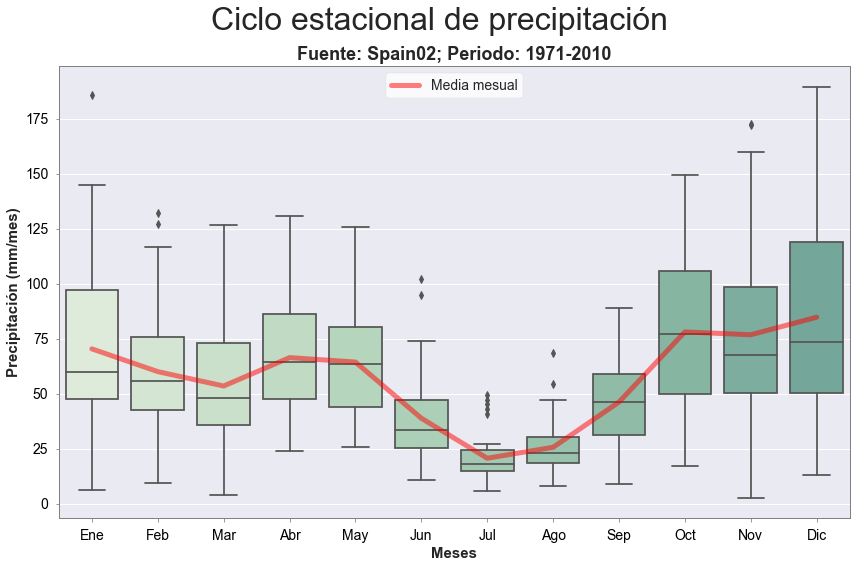

In [603]:
fig, ax = climograma(df_pcpm,1971,2010,'pr', fuente='Spain02',save=True,figname='tmax_boxplot',
            suptitle='Ciclo estacional de precipitación',ylabel='Precipitación (mm/mes)',palette=sns.color_palette("ch:start=0.2,rot=-0.5,dark=0.6, light=.9",12))


#### Distribución espacial de la precipitación en julio

In [477]:
# Selección de julio y cálculo de percentiles
pcp7xr = pcp_msum.sel(time=pcp_msum.time.dt.month==7)
mpcp = pcp7xr.mean('time')
p95pcp = pcp7xr.quantile(0.95,dim='time')
p5pcp = pcp7xr.quantile(0.05,dim='time')

c:\Users\digar7\anaconda3\envs\env1\lib\site-packages\numpy\lib\nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Text(0.5, 0.98, 'Precipitaciones durante el mes de julio (1971-2010)')

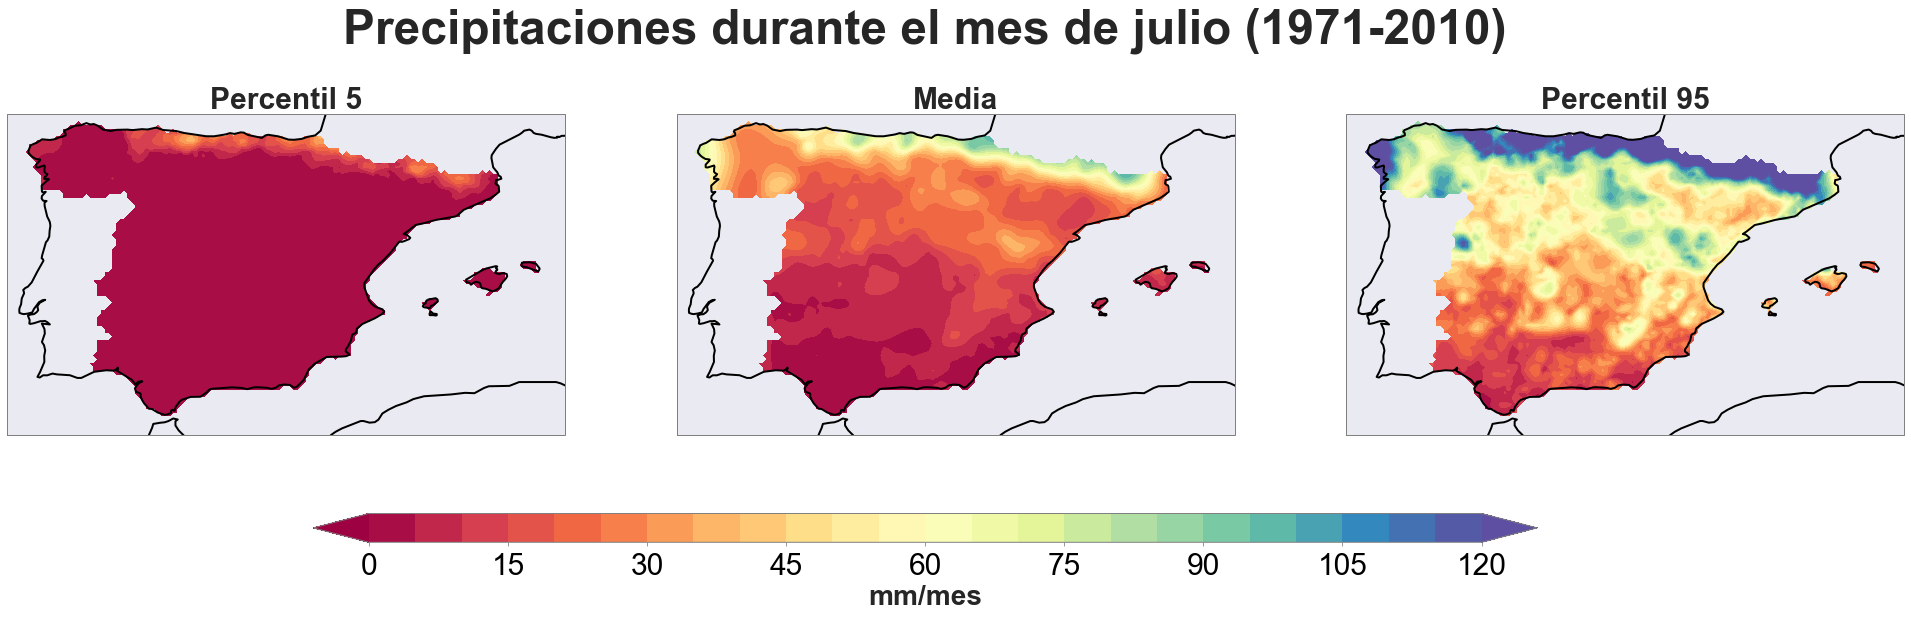

In [608]:

fig, ax = plt.subplots(1,3,figsize=(34,8),facecolor='w', subplot_kw={'projection': ccrs.PlateCarree(0)}) 
ax=ax.ravel().tolist()
step = 5
levels = np.arange(0,120+step,step)
var_list = [p5pcp,mpcp,p95pcp]
titulos = [r'Percentil 5',r'Media',r'Percentil 95']
for i in range(3):

    var = var_list[i]
    im=ax[i].contourf(lon_pcp,lat_pcp,var,cmap='Spectral',levels=levels,extend='both',transform=ccrs.PlateCarree())
    ax[i].coastlines(linewidth=2,resolution='50m')
    ax[i].set_title(titulos[i],fontsize=30)
    ax[i].set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())

plt.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal',shrink=0.6)
cbar.set_label('mm/mes', size=28)
cbar.ax.tick_params(labelsize=30) 
fig.suptitle(u'Precipitaciones durante el mes de julio (1971-2010)',size= 48, fontweight='bold')


Desviación estándar:

In [498]:
stdpcp = pcp7xr.std('time')

Text(0.5, 0.98, 'Precipitaciones en julio (1971-2010)')

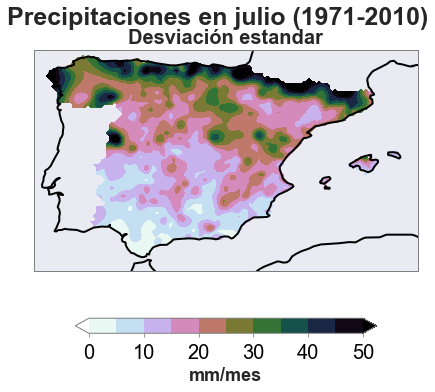

In [609]:
fig, ax = plt.subplots(1,1,figsize=(9,6),facecolor='w', subplot_kw={'projection': ccrs.PlateCarree(0)}) 

step = 5
levels = np.arange(0,50+step,step)
titulo = u'Desviación estandar'

var = stdpcp
im=ax.contourf(lon_pcp,lat_pcp,var,cmap='cubehelix_r',levels=levels,extend='both',transform=ccrs.PlateCarree())
ax.coastlines(linewidth=2,resolution='50m')
ax.set_title(titulo,fontsize=20)
ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())

plt.subplots_adjust(bottom=0.15)
cbar = plt.colorbar(im, orientation='horizontal',shrink=0.6)
cbar.set_label('mm/mes', size=18)
cbar.ax.tick_params(labelsize=20) 
fig.suptitle(u'Precipitaciones en julio (1971-2010)',size= 25, fontweight='bold')

#### Histograma PCP (julio)

In [468]:
# Consideramos el mes de julio (medias diarias)
df_pcp7 = df_pcpm[df_pcpm['month']==7]

Los percentiles para los datos son: q(5%)=7.47 and q(95%)= 45.19
Los percentiles teóricos para los datos son: q(5%)=2.54 and q(95%)= 38.68

Media:  20.61
Índice de Confianza del 95% para la media: 20.61+-3.4
Con la función de scipy (ic1,ic2): (17.21,24.02)

Varianza:  117.7
Índice de Confianza del 95% para la varianza (ic1,ic2): (78.98,194.06)
Con la función de scipy (ic1,ic2): (78.98,194.06)

La asimetría es 1.21 y el valor teórico  0.0
La curtosis es 0.92 y el valor teórico  0.0


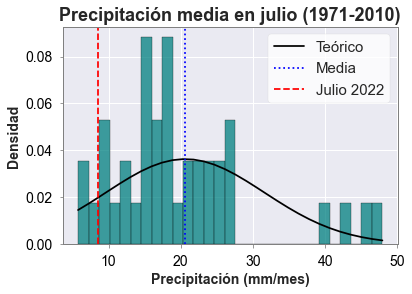

In [475]:
fig,ax,mean,ic_scipy,std = histogram_plotter_with_normal_estimation(df_pcp7,'pr','Precipitación (mm/mes)','Precipitación media en julio (1971-2010)',color='teal')
vline = ax.axvline(mean,color='b',linestyle=':',label='Media')
pcp_aemet2022 = 8.6
vline2 = ax.axvline(pcp_aemet2022,color='r',linestyle='--',label='Julio 2022')
leg = ax.legend()

#### Evolución temporal de la precipitación mesual

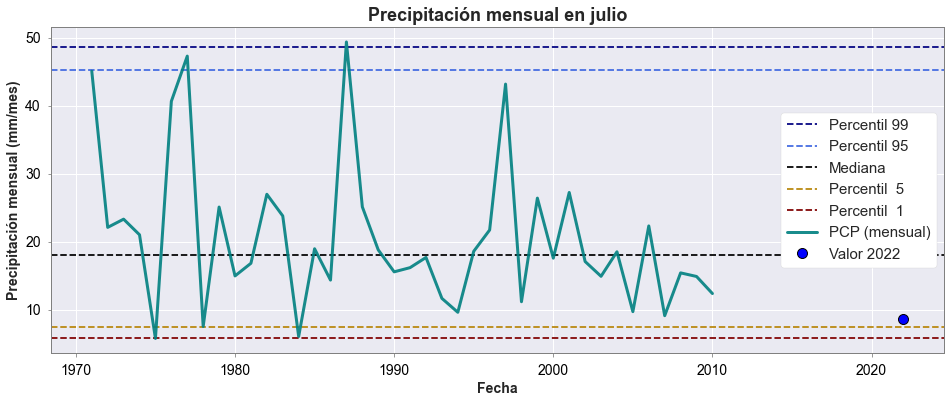

In [612]:
fig,ax = plt.subplots(figsize = (16,6),facecolor='w')

ax.axhline(df_pcp7['pr'].quantile(0.99),color='navy',linestyle='--',label='Percentil 99')
ax.axhline(df_pcp7['pr'].quantile(0.95),color='royalblue',linestyle='--',label='Percentil 95')
ax.axhline(df_pcp7['pr'].quantile(0.5),color='k',linestyle='--',label='Mediana')
ax.axhline(df_pcp7['pr'].quantile(0.05),color='darkgoldenrod',linestyle='--',label='Percentil  5')
ax.axhline(df_pcp7['pr'].quantile(0.01),color='maroon',linestyle='--',label='Percentil  1')


ax.plot(df_pcp7.year,df_pcp7['pr'],linewidth=3,alpha=0.9,label=r'PCP (mensual)',color='teal')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precipitación mensual (mm/mes)')
ax.set_title('Precipitación mensual en julio')
ax.plot(2022,pcp_aemet2022,'bo',label='Valor 2022',markeredgecolor='black',markeredgewidth=1,markersize=10)

ax.legend(framealpha=1) # Leyenda con título



In [614]:
fig.savefig('serie_pcp.png',dpi=100,facecolor='w')

## Contraste de hipóteis y contextualización de la ola de calor de 2022

In [235]:
def ContrasteHipotesis_1pob(x1,x0,alpha):
    ''' Esta función calcula el contraste de hipótesis con un nivel de significancia alpha '''
    
    # Número de datos de la serie
    n1=x1.size

    #-------------------------------------------------------
    # Contraste de hipótesis de la media
    #-------------------------------------------------------
    # Calculo el estadístico
    z=np.abs(np.mean(x1)-x0)/(np.sqrt((np.var(x1)/n1)))

    # Calculo valor con el que voy a comparar la muestra, sigue una distribución normal, usamos norm.ppf. Hay que tener
    # en cuenta que z_alpha_2 es el valor que deja a su derecha un área de alpha_1, pero la función del paquete scipy
    # stats.norm.ppf() devuelve el valor que deja por DEBAJO, por lo que se tiene que introducir 1-alpha_2
    z_alpha_2 = stats.norm.ppf(1-alpha/2,loc=0,scale=1)
    print(z)
    print(z_alpha_2)
    # Comprobamos si se cumplen las premisas
    if z<=z_alpha_2:
        # En este caso se acepta la hipótesis
        print('Se acepta la hipótesis de que la media sea igual al valor con un nivel de significancia ', alpha)
    else:
        # En este caso no se acepta la hipótesis
        print('Se rechaza la hipótesis de que la media sea igual al valor con un nivel de significancia ', alpha)

In [397]:
ContrasteHipotesis_1pob(df_tmean7m.tm,media2022,0.05)

27.90246841017668
1.959963984540054
Se rechaza la hipótesis de que la media sea igual al valor con un nivel de significancia  0.05


> El valor de temperatura de 2022 se sale por muchísimo del intervalo de confianza de la media mensual de julio, por lo que con el contraste de hipótesis obtenemos que el valor es significativamente diferente de la media con una confianza del 95%.

In [476]:
ContrasteHipotesis_1pob(df_pcp7.pr,pcp_aemet2022,0.05)

7.001650553842697
1.959963984540054
Se rechaza la hipótesis de que la media sea igual al valor con un nivel de significancia  0.05


> El valor de precipitación es también significativamente diferente de la media del periodo de referencia. 

---

# 2. Análisis Univariante 

In [237]:
anom2022 = xr.open_dataset('slpjul2022_min_19602010.nc')
anom2022

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 1)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 2022-07-01
Data variables:
    slp      (time, lat, lon) float32 ...
Attributes:
    title:        Composite Value
    history:      Season is Jul to Jul; Years used in composite:  2022 -1960 ...
    description:  Computed from the web page http://www.esrl.noaa.gov/psd/dat...
    Conventions:  COARDS

Tenemos datos para todo el mundo, pero para el índice nos interesará más utilizar datos en la zona de Europa, como lo que se muestra en el enunciado del examen.

Selecciono la sección del mapa de mayor interés:

In [238]:
# Primero voy a cambiar las longitudes para que estén en -180 a 180
anom2022 = anom2022.assign_coords(lon=(((anom2022.lon + 180) % 360) - 180)).sortby('lon')['slp']
anom2022

<xarray.DataArray 'slp' (time: 1, lat: 73, lon: 144)>
[10512 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * time     (time) datetime64[ns] 2022-07-01
Attributes:
    long_name:     Sea Level Pressure
    valid_range:   [-99999.  99999.]
    actual_range:  [-15.705372 377.2     ]
    units:         millibars
    precision:     99
    var_desc:      Sea Level Pressure
    dataset:       CDC Derived NCEP Reanalysis Products
    level_desc:    
    statistic:     Composite
    parent_stat:   Other

In [239]:
anom2022_eu = anom2022.sel(lon=slice(-30,45),lat=slice(80,20)).squeeze()
anom2022_eu

<xarray.DataArray 'slp' (lat: 25, lon: 31)>
[775 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 80.0 77.5 75.0 72.5 70.0 ... 30.0 27.5 25.0 22.5 20.0
  * lon      (lon) float32 -30.0 -27.5 -25.0 -22.5 -20.0 ... 37.5 40.0 42.5 45.0
    time     datetime64[ns] 2022-07-01
Attributes:
    long_name:     Sea Level Pressure
    valid_range:   [-99999.  99999.]
    actual_range:  [-15.705372 377.2     ]
    units:         millibars
    precision:     99
    var_desc:      Sea Level Pressure
    dataset:       CDC Derived NCEP Reanalysis Products
    level_desc:    
    statistic:     Composite
    parent_stat:   Other

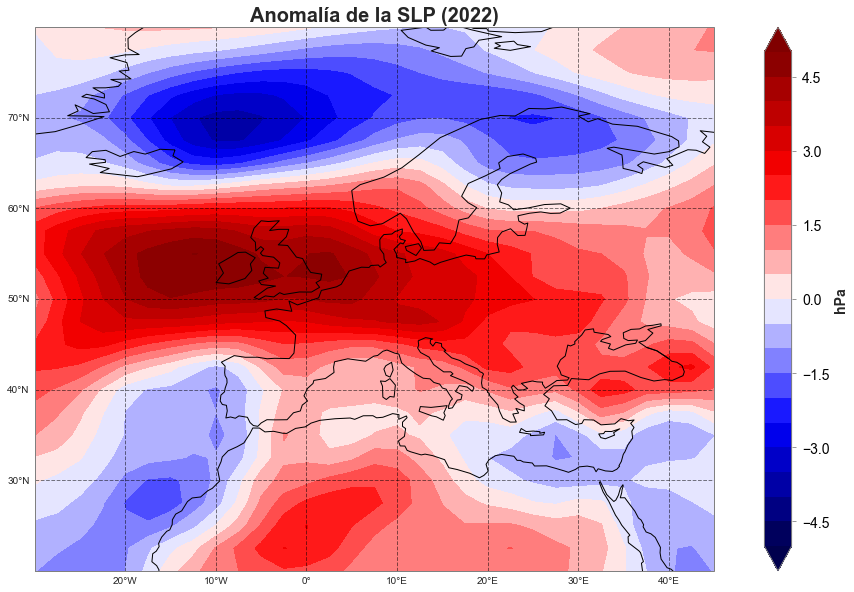

In [240]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))

var = anom2022_eu
rang = max((abs(var.min()),abs(var.max())))
step = 0.5
rang = 5
levels = np.arange(-rang,rang+step,step)

im = ax.contourf(var.lon,var.lat,var,levels,cmap='seismic',extend='both')
ax.coastlines(linewidth=1)
fig.colorbar(im,ax=ax,label='hPa')
ax.set_title('Anomalía de la SLP (2022)',size=20)
gl=ax.gridlines(draw_labels = True,color='k', alpha=0.5, linestyle='--')
gl.right_labels = False
gl.top_labels = False

Con esta representación se observa mucho más claramente que el centro de anomalía negativa cerca de la Península es mucho más débil que los demás. Con esto en mente, trataré de elaborar el índice probando distintas formas.

## Índice temporal de presión

Primero seleccionaré tres regiones donde se encuentran las anomalías principales:

In [241]:
R1 = anom2022_eu.sel(lon=slice(-20,5),lat=slice(75,65))
R2 = anom2022_eu.sel(lon=slice(-25,10),lat=slice(60,45))
R3 = anom2022_eu.sel(lon=slice(-25,-10),lat=slice(40,25))

In [242]:
# Promedios de cada zona
R1m = R1.mean(dim=['lon','lat'])
R2m = R2.mean(dim=['lon','lat'])
R3m = R3.mean(dim=['lon','lat'])

Primero lo haré considerando las restas con un solo punto localizado en los centros de las anomalías:

In [243]:
# Valores extremos
R1p = float(R1.min())
R2p = float(R2.max())
R3p = float(R3.min())

In [244]:
# Posición de los centros 
p1 = R1[np.where(R1==R1p)]
p2 = R2[np.where(R2==R2p)]
p3 = R3[np.where(R3==R3p)]

Voy a representar las regiones y las posiciones de los centros:

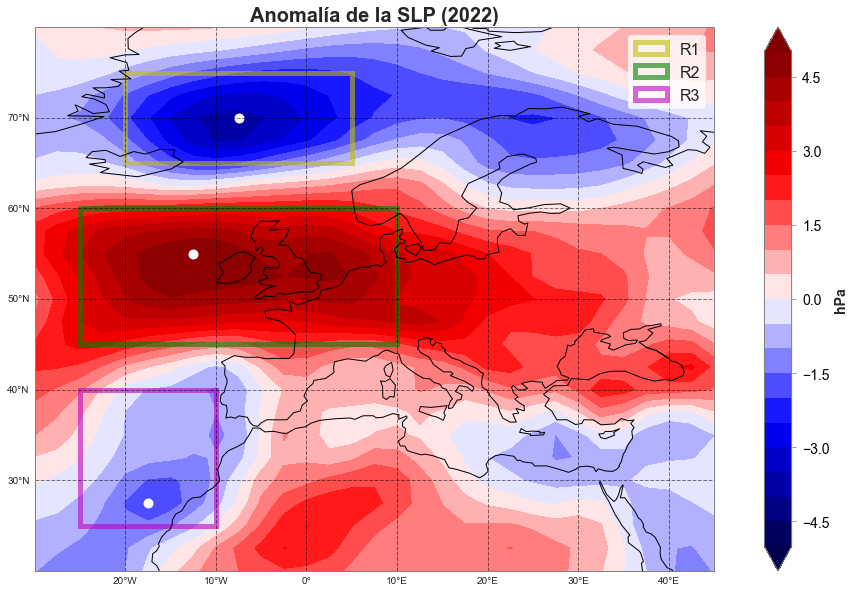

In [245]:
def pinta_region(lats,lons,color,ax=ax,label=None,fill=True,lw=1):
    '''Esta función nos servirá para pintar rectángulos con las regiones'''
    lat_corners = np.array([lats[0], lats[0],lats[-1], lats[-1]])
    lon_corners = np.array([ lons[0], lons[-1], lons[-1], lons[0]])
    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners
    poly = mpatches.Polygon(poly_corners, closed=True, ec=color, fill=fill, lw=lw, fc=color,label=label,alpha=0.6)
    ax.add_patch(poly)

fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))

var = anom2022_eu
rang = max((abs(var.min()),abs(var.max())))
step = 0.5
rang = 5
levels = np.arange(-rang,rang+step,step)

im = ax.contourf(var.lon,var.lat,var,levels,cmap='seismic',extend='both')
ax.coastlines(linewidth=1)
fig.colorbar(im,ax=ax,label='hPa')
ax.set_title('Anomalía de la SLP (2022)',size=20)
gl=ax.gridlines(draw_labels = True,color='k', alpha=0.5, linestyle='--')
gl.right_labels = False
gl.top_labels = False
pinta_region(R1.lat,R1.lon,'y',ax,label='R1',fill=False,lw=5)
pinta_region(R2.lat,R2.lon,'g',ax,label='R2',fill=False,lw=5)
pinta_region(R3.lat,R3.lon,'m',ax,label='R3',fill=False,lw=5)
ax.plot(p1.lon,p1.lat,'wo',markersize=10)
ax.plot(p2.lon,p2.lat,'wo',markersize=10)
ax.plot(p3.lon,p3.lat,'wo',markersize=10)

ax.legend(prop={'size':16})

### Lectura de los datos de presión:

In [246]:
path1='../Multivariante/data/'
file_slp ='slp_ERA20_1900-2010.nc'
setSLP = xr.open_dataset(path1+file_slp)


# Voy a cambiar las longitudes para que estén en -180 a 180
slp = setSLP.assign_coords(longitude=(((setSLP.longitude + 180) % 360) - 180)).sortby('longitude')['msl']
slp = slp.sel(time=slice('1960','2010'))

In [247]:
# Selección de los meses de Julio, lo pongo en hPa y considero anomalías
slp7 = slp.sel(time=slp.time.dt.month==7)/100
slp7 = slp7-slp7.mean('time')
slp7

<xarray.DataArray 'msl' (time: 51, latitude: 181, longitude: 360)>
array([[[ 1.673523  ,  1.673523  ,  1.673523  , ...,  1.673523  ,
          1.673523  ,  1.673523  ],
        [ 1.3934937 ,  1.380249  ,  1.3682251 , ...,  1.434082  ,
          1.4212036 ,  1.4063721 ],
        [ 1.2484741 ,  1.2212524 ,  1.1956787 , ...,  1.3278198 ,
          1.3009033 ,  1.2757568 ],
        ...,
        [-1.9152832 , -1.9286499 , -1.9414062 , ..., -1.8782959 ,
         -1.8895874 , -1.9025879 ],
        [-1.932373  , -1.9384155 , -1.9442749 , ..., -1.9190063 ,
         -1.9230347 , -1.9283447 ],
        [-2.2370605 , -2.2370605 , -2.2370605 , ..., -2.2370605 ,
         -2.2370605 , -2.2370605 ]],

       [[ 0.0604248 ,  0.0604248 ,  0.0604248 , ...,  0.0604248 ,
          0.0604248 ,  0.0604248 ],
        [-0.394104  , -0.4058838 , -0.41931152, ..., -0.3505249 ,
         -0.36340332, -0.37835693],
        [-0.8312378 , -0.8584595 , -0.88397217, ..., -0.7503662 ,
         -0.7772827 , -0.8024292 ],
...
        [ 3.2235107 ,  3.220337  ,  3.2148438 , ...,  3.2372437 ,
          3.2332764 ,  3.227539  ],
        [ 2.2980957 ,  2.293518  ,  2.2877197 , ...,  2.2999268 ,
          2.298767  ,  2.2978516 ],
        [ 1.0153809 ,  1.0153809 ,  1.0153809 , ...,  1.0153809 ,
          1.0153809 ,  1.0153809 ]],

       [[-7.9312134 , -7.9312134 , -7.9312134 , ..., -7.9312134 ,
         -7.9312134 , -7.9312134 ],
        [-8.419128  , -8.417847  , -8.416748  , ..., -8.41626   ,
         -8.4175415 , -8.417847  ],
        [-8.809753  , -8.809387  , -8.811707  , ..., -8.805908  ,
         -8.806641  , -8.807129  ],
        ...,
        [-9.543579  , -9.5598755 , -9.574036  , ..., -9.499329  ,
         -9.514954  , -9.529358  ],
        [-9.687134  , -9.690308  , -9.693176  , ..., -9.692566  ,
         -9.689392  , -9.687378  ],
        [-9.978699  , -9.978699  , -9.978699  , ..., -9.978699  ,
         -9.978699  , -9.978699  ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1960-07-01 1961-07-01 ... 2010-07-01

### Índice con el promedio de las regiones:

In [248]:
R1_slp = slp7.sel(longitude=slice(-20,5),latitude=slice(75,65))
R2_slp = slp7.sel(longitude=slice(-25,10),latitude=slice(60,45))
R3_slp = slp7.sel(longitude=slice(-25,-10),latitude=slice(40,25))

In [249]:
R1m_slp = R1_slp.mean(dim=['longitude','latitude'])
R2m_slp = R2_slp.mean(dim=['longitude','latitude'])
R3m_slp = R3_slp.mean(dim=['longitude','latitude'])

In [250]:
index_regions = (R2m_slp-R1m_slp)+(R2m_slp-R3m_slp)
index_regions /= ((R2m-R1m)+(R2m-R3m)) # Divido entre el valor de 2022
index_regions

<xarray.DataArray 'msl' (time: 51)>
array([-0.86663795,  0.1050458 , -0.43975738,  0.14516377,  0.81372213,
       -0.77113336,  0.5768124 ,  0.01743361,  0.26196036,  0.86054933,
        0.12429614,  0.48224264,  0.51443195, -0.1548067 ,  0.2967758 ,
        0.4509193 ,  0.08054912, -0.31921208, -0.33684325,  0.38964823,
       -0.8140517 ,  0.3952759 ,  0.8625247 ,  0.7810461 ,  0.33905888,
       -0.20642617,  0.25625417,  0.0459741 , -0.9550632 ,  1.2175311 ,
        0.16603097, -0.3681493 , -0.1772588 , -0.09611607,  0.11429475,
       -0.04223411,  0.5259798 , -0.18393388, -0.2883385 ,  0.24562126,
       -0.21613605, -0.39613733,  0.01056386, -0.6482155 ,  0.22003028,
        0.02858396,  0.21462981, -0.9683864 , -0.7613137 , -1.3089148 ,
       -0.22385418], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1960-07-01 1961-07-01 ... 2010-07-01

In [251]:
# Calculo la anomalías estandarizada
index_regions_std = (index_regions-index_regions.mean())/index_regions.std()
index_regions_std

<xarray.DataArray 'msl' (time: 51)>
array([-1.65158263,  0.20018826, -0.83806177,  0.27664245,  1.55073689,
       -1.46957629,  1.0992499 ,  0.03322271,  0.49922565,  1.63997708,
        0.23687428,  0.91902512,  0.98036939, -0.29502152,  0.56557461,
        0.85933116,  0.1535041 , -0.60833448, -0.64193481,  0.74256478,
       -1.5513672 ,  0.75328961,  1.64374158,  1.48846504,  0.64615493,
       -0.39339451,  0.48835117,  0.0876133 , -1.8200977 ,  2.32028938,
        0.31640978, -0.70159583, -0.33780926, -0.18317279,  0.21781429,
       -0.0804881 ,  1.00237654, -0.35053018, -0.54949767,  0.46808771,
       -0.41189896, -0.75493355,  0.0201308 , -1.23532747,  0.4193181 ,
        0.05447231,  0.40902625, -1.84548815, -1.45086258, -2.49444468,
       -0.42660766])
Coordinates:
  * time     (time) datetime64[ns] 1960-07-01 1961-07-01 ... 2010-07-01

### Índice solo con los centros:

In [252]:
R1p_slp = slp7.sel(longitude=float(p1.lon),latitude=float(p1.lat),method ='nearest')
R2p_slp = slp7.sel(longitude=float(p2.lon),latitude=float(p2.lat),method ='nearest')
R3p_slp = slp7.sel(longitude=float(p3.lon),latitude=float(p3.lat),method ='nearest')


In [253]:
index_points = (R2p_slp-R1p_slp)+(R2p_slp-R3p_slp)
index_points /= ((R2p-R1p)+(R2p-R3p)) # Divido entre el valor de 2022
index_points

<xarray.DataArray 'msl' (time: 51)>
array([-9.5881212e-01,  2.8826919e-01, -2.8897074e-01,  5.7683460e-04,
        4.6125332e-01, -5.2542615e-01,  6.4222735e-01, -2.0739542e-01,
        5.3605473e-01,  6.2931871e-01,  1.5243243e-02,  4.4352344e-01,
        3.7670416e-01, -6.0575426e-02,  1.6401200e-01,  2.8715059e-01,
        1.2647488e-02, -1.0502287e-01, -1.4752935e-01,  3.0097514e-01,
       -6.1070412e-01,  3.0274463e-01,  8.7607920e-01,  7.6611036e-01,
        4.2766050e-01, -2.7625310e-01,  1.0062256e-01,  1.2660740e-01,
       -1.0075313e+00,  1.0548239e+00,  1.5027711e-01, -4.3568552e-01,
       -2.0664319e-01, -7.3117684e-03, -1.5188678e-02, -1.4019808e-01,
        4.0259936e-01, -1.3872093e-01, -1.3203666e-01,  2.4845591e-01,
        5.4031473e-02, -1.9941717e-01,  7.3059216e-02, -6.0922307e-01,
        1.3393475e-01,  1.7402865e-01,  6.6102124e-03, -6.7742985e-01,
       -6.4310431e-01, -1.2126349e+00, -4.4933075e-01], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1960-07-01 1961-07-01 ... 2010-07-01

In [254]:
# Calculo la anomalías estandarizada
index_points_std = (index_points-index_points.mean())/index_points.std()
index_points_std

<xarray.DataArray 'msl' (time: 51)>
array([-2.05810154e+00,  6.18748265e-01, -6.20292511e-01,  1.21897711e-03,
        9.90057266e-01, -1.12784211e+00,  1.37851655e+00, -4.45191758e-01,
        1.15061789e+00,  1.35080827e+00,  3.27003038e-02,  9.52000228e-01,
        8.08573191e-01, -1.30043845e-01,  3.52031221e-01,  6.16347198e-01,
        2.71285364e-02, -2.25449920e-01, -3.16689728e-01,  6.46021486e-01,
       -1.31089058e+00,  6.49819667e-01,  1.88047763e+00,  1.64443041e+00,
        9.17950553e-01, -5.92994213e-01,  2.15966302e-01,  2.71742561e-01,
       -2.16267683e+00,  2.26415160e+00,  3.22549388e-01, -9.35214576e-01,
       -4.43577112e-01, -1.57138449e-02, -3.26215662e-02, -3.00953224e-01,
        8.64157042e-01, -2.97782529e-01, -2.83434790e-01,  5.33289386e-01,
        1.15958922e-01, -4.28066519e-01,  1.56801817e-01, -1.30771151e+00,
        2.87470654e-01,  3.73531878e-01,  1.41695725e-02, -1.45411682e+00,
       -1.38043733e+00, -2.60293010e+00, -9.64503954e-01])
Coordinates:
  * time     (time) datetime64[ns] 1960-07-01 1961-07-01 ... 2010-07-01

### Índice con covarianza

In [255]:
# Debemos seleccionar el mismo área
slp7_eu = slp7.sel(longitude=slice(-30,45),latitude=slice(80,20))

# Y hay que hacer un remallado porque la cantidad de puntos ns no es la misma en esta serie y en la de 2022
slp7_eu_rm = slp7_eu.interp(longitude=np.array(anom2022_eu.lon)).interp(latitude=np.array(anom2022_eu.lat))


In [256]:
# Cambiamos la forma de los arrays
anom2022_ns = np.reshape(anom2022_eu,(anom2022_eu.lon.size*anom2022_eu.lat.size,1))
slp7_nsnt = np.reshape(np.array(slp7_eu_rm),(slp7_eu_rm.time.size,slp7_eu_rm.longitude.size*slp7_eu_rm.latitude.size)).T
print(anom2022_ns.shape)
print(slp7_nsnt.shape)

(775, 1)
(775, 51)


In [257]:
index_cov = np.dot(anom2022_ns.T,slp7_nsnt)

In [258]:
# Calculo la anomalías estandarizada
index_cov_std = np.squeeze((index_cov-index_cov.mean())/index_cov.std())
index_cov_std

array([-1.3798599 ,  0.38778323, -0.46755052,  0.46672   ,  1.7247975 ,
       -0.95265436,  0.9473181 ,  0.62506586,  0.86695915,  1.8893144 ,
        0.19867547,  1.105885  ,  0.8854759 , -0.6905443 ,  0.391862  ,
        0.37468946, -0.16756491, -0.59420455, -0.40972158,  0.9084981 ,
       -1.707621  ,  0.8390533 ,  1.7010435 ,  1.224307  ,  0.78595674,
       -0.41033083,  0.47842735,  0.01953216, -1.648271  ,  2.3350728 ,
       -0.05833303, -0.8028314 , -0.17524922, -0.15657248, -0.08561613,
       -0.40390745,  1.1039485 , -0.45201275, -1.0181085 ,  0.16806757,
       -1.1311721 , -0.4199644 , -0.07829235, -1.2790681 ,  0.15240662,
       -0.04139133,  0.86573774, -1.8705021 , -1.4222145 , -2.1579688 ,
       -0.465069  ], dtype=float32)

### Representación de las tres formas de hallar el índice

(-3.5, 3.5)

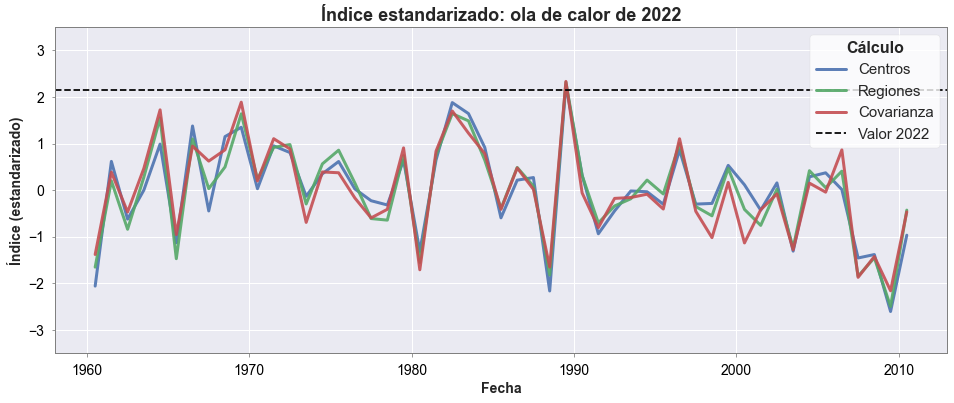

In [621]:
fig,ax = plt.subplots(figsize = (16,6))
ax.plot(index_points_std.time,index_points_std,linewidth=3,alpha=0.9,label='Centros')
ax.plot(index_regions_std.time,index_regions_std,linewidth=3,alpha=0.9,label='Regiones')
ax.plot(index_regions_std.time,index_cov_std,linewidth=3,alpha=0.9,label='Covarianza')
ax.set_xlabel('Fecha')
ax.set_ylabel('Índice (estandarizado)')
ax.set_title('Índice estandarizado: ola de calor de 2022')
ax.axhline((1-index_points.mean())/index_points.std(),color='k',linestyle='--',label='Valor 2022')

ax.legend(title='Cálculo',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_ylim(-3.5,3.5)


> Observamos resultados prácticamente idénticos para las tres formas de calcular el índice.

### Correlación entre las distintas formas de hallar el índice

Para asegurar se puede calcular la correlación entre estos tres índices:

In [260]:
corr1 = pearsonr(index_points_std,index_cov_std)[0]
corr2 = pearsonr(index_points_std,index_regions_std)[0]
corr3 = pearsonr(index_regions_std,index_cov_std)[0]
print('Correlación entre el índice con los centros y con covarianza:   '+str(np.round(corr1,4)))
print('Correlación entre el índice con los centros y con las regiones: '+str(np.round(corr2,4)))
print('Correlación entre el índice con las regiones y con covarianza:  '+str(np.round(corr3,4)))

Correlación entre el índice con los centros y con covarianza:   0.9144
Correlación entre el índice con los centros y con las regiones: 0.9595
Correlación entre el índice con las regiones y con covarianza:  0.9636


=> La correlación es muy alta en todos los casos. Las tres formas de hallar el índice son válidas y llevan a resultados similares. 

> Para el resto del estudio tomaré el calculado en base a la covarianza de los mapas, aunque al ser muy parecidos valdría cualquiera. 

## Análisis del índice de presión

### Análisis espectral

In [624]:
years = np.arange(1960,2010+1)

>>Serie de días fríos:
La varianza de la serie es  0.8690537810325623
La integral del espectro es  0.8690538527444005


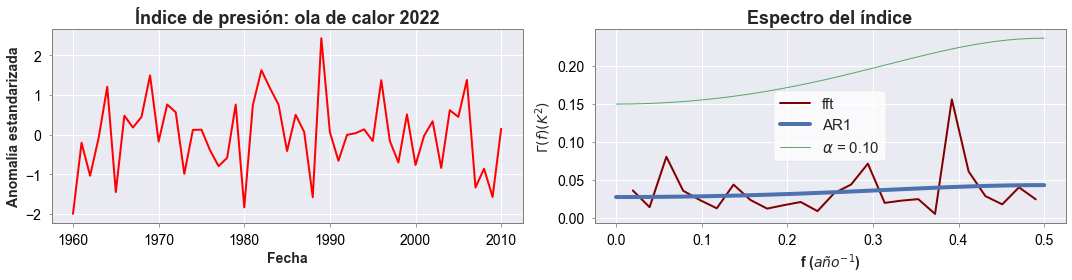

In [644]:
fig, ax=plt.subplots(1,2,figsize=(15,4))

x = signal.detrend(index_cov_std)
#x1 = index_cov_std
x2 = index_regions_std
x3 = index_points_std
ax[0].plot(years,x,color='red',linewidth=2)
#ax[0].plot(years,x1,color='g',linewidth=2)

ax[0].set_ylabel(u'Anomalía estandarizada')
ax[0].set_xlabel('Fecha')
ax[0].set_title(u'Índice de presión: ola de calor 2022')


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ff1,Gf1 = espectroFFT(x1,1)
ff2,Gf2 = espectroFFT(x2,1)
ff3,Gf3 = espectroFFT(x3,1)

#ax[1].plot(fa,Ga,linewidth=1)
#ax[1].plot(ff2,Gf2,label='fft',color='g')
#ax[1].plot(ff3,Gf3,label='fft',color='navy')
ax[1].plot(ff,Gf,label='fft',color='maroon',linewidth=2)
#ax[1].plot(ff1,Gf1,label='fft',color='g')


ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($año^{-1}$)')
ax[1].set_title('Espectro del índice')

ff_d = ff # Lo guardo
Gf_d = Gf # Lo guardo

print('>>Serie de días fríos:')
print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax[1].legend()


plt.tight_layout()

=> No se observa ningún pico significativo al 90% de confianza. Aunque si que podemos ver que hay un pico claramente más marcado que el resto del espectro en torno a los 0.4 $años^{-1}$. El filtrado se puede tratar de realizar teniendo en cuenta dicho pico.

### Filtrado

In [630]:
# Posición del pico de mayor poder espectral
cut0 = 1/ff[np.argmax(Gf)]
print('-> Periodicidad de %.2f años.'%(cut0))

-> Periodicidad de 2.55 años.


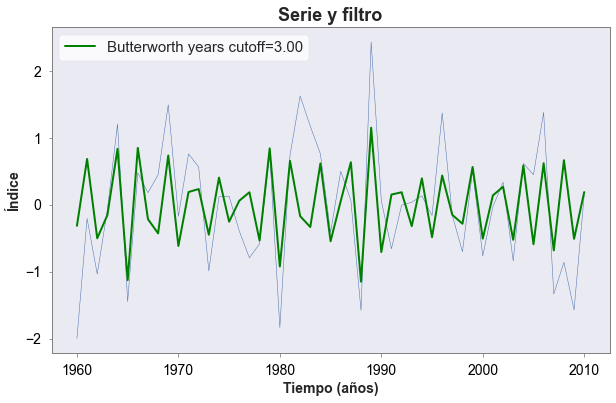

In [652]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

cut = cut0+0.45 # Para quitar algo más alrededor de esa frecuencia
# La señal inicial
x = signal.detrend(index_cov_std)

t = years
N = x.size
ax.plot(t,x,linewidth=0.5) # Represento la serie


#Voy a usar la condición mínima derivada en ambos extremos:
xtot = np.append(np.flip(x),[x,np.flip(x)])

# frecuencia de corte (en meses) (15 años):
nyc = cut
Tc = nyc 
fc = 1 / Tc

#Media móvil: necesito una ventana de aprox. Tc/0.443
Window = int(0.443/fc)

#Filtro la señal ampliada y luego me quedo con el trozo central
ytot = runningMean(xtot,Window)
yRunningMean = ytot[N:2*N]


#Filtro de Butterworth, escogemos orden nominal 4
#Cuidado que el filtro de Butter tiene la frecuencia normalizada con 1 correspondiendo a fmax=FNyquist
n = 4
b,a = signal.butter(n,fc*2,output='ba',btype='highpass')
#Filtro la señal ampliada y me quedo con la parte central:
ytot = signal.filtfilt(b,a,xtot)
yButter = ytot[N:2*N]


ax.grid()
ax.set_title('Serie y filtro')
ax.set_xlabel('Tiempo (años)')
ax.set_ylabel(u'Índice')
ax.plot(t,yButter,linewidth= 2,color='green',label='Butterworth years cutoff=%.2f'%(nyc)) # Filtro Butter
#ax.plot(t,x-yButter,linewidth= 2,color='green',label='Butterworth years cutoff=%.2f'%(nyc)) # Filtro Butter

ax.legend()

La varianza de la serie es  0.31243932621846215
La integral del espectro es  0.3124393262184621


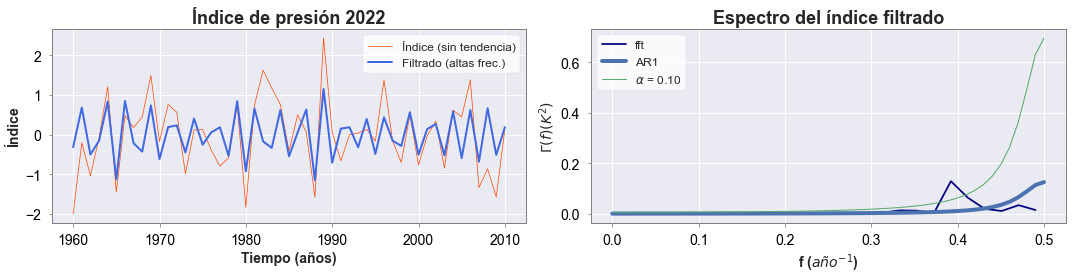

In [653]:
fig, ax=plt.subplots(1,2,figsize=(15,4))

x = yButter
time = years
ax[0].plot(time,signal.detrend(index_cov_std),color='orangered',label='Índice (sin tendencia)',linewidth=0.7)

ax[0].plot(time,x,color='royalblue',label='Filtrado (altas frec.)', linewidth=2)

ax[0].set_title(u'Índice de presión 2022')
ax[0].set_xlabel('Tiempo (años)')
ax[0].set_ylabel(u'Índice')
ax[0].legend(prop={'size':12})


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
ax[1].plot(ff,Gf,label='fft',color='navy')
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($año^{-1}$)')
ax[1].set_title('Espectro del índice filtrado')

ff_d = ff # Lo guardo
Gf_d = Gf # Lo guardo


print('La varianza de la serie es ',float(np.var(x)))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.1
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
N = x.size
s2 = float(np.var(x))
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
# a = 0 #Para ruido blanco
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = %.2f'%(alpha))
a,s2,chi2
ax[1].legend(prop={'size':12})



plt.tight_layout()

## Valores de retorno de las temperaturas máximas en la Península

Tomaré el promedio de toda la España peninsular para obtener un dato para cada uno delos días de los múltiples julios. Después consideraré el valor máximo de cada año y aplicaré GEV para hallar el valor de retorno. 

In [537]:
maxesp = tmax7.mean(dim=['lat','lon']).groupby('time.year').max('time')

In [539]:
#Ajuste usando herramienta de scipy:
x = maxesp.copy()
c, m, s = stats.genextreme.fit(x)
c = - c
print('MLE ='+'%.3f'%(MLE_GEV(c,m,s,x)))
print('c='+'%.3f'%(c))
print('m='+'%.3f'%(m))
print('s='+'%.3f'%(s))

MLE =83.877
c=-0.380
m=32.443
s=1.338


In [541]:
print('100yr return value = '+'%.1f'%(returnLevel(0.01,c,m,s)))

100yr return value = 35.4


C:\Users\digar7\AppData\Local\Temp/ipykernel_28360/3853450587.py:22: RuntimeWarning: invalid value encountered in power
  g = ( np.power( 1 + c * y , -1-1/c) ) * np.exp( - np.power(1 + c * y ,-1/c) ) / s


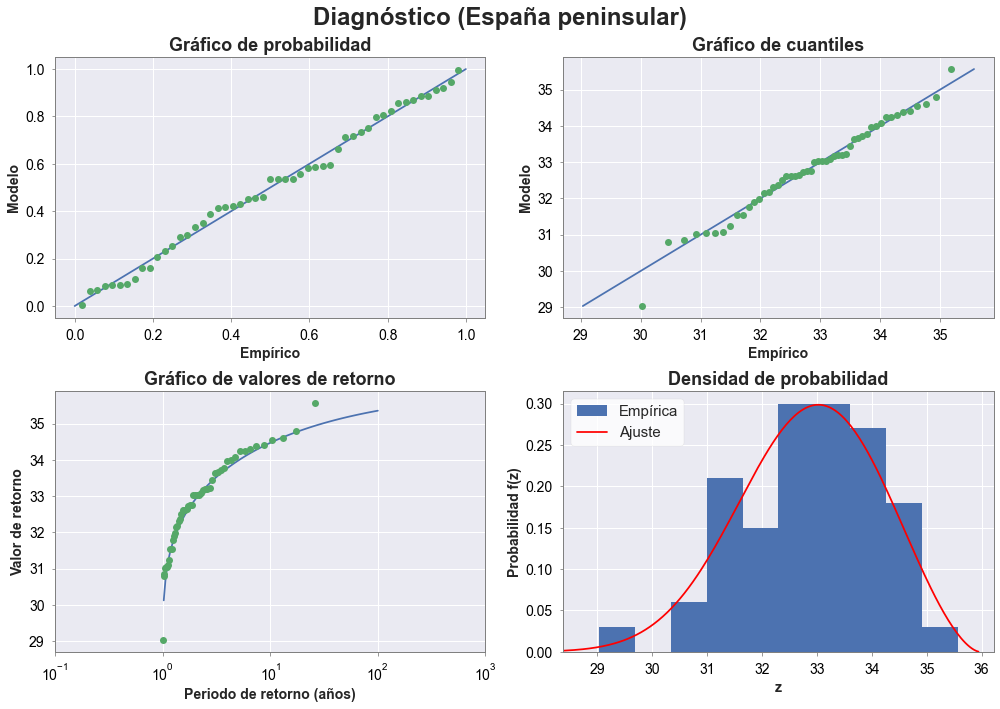

In [553]:
fig, ax = diagnosticsGEV(x,c,m,s)
text = fig.suptitle('Diagnóstico (España peninsular)',weight='bold',fontsize=24)

## Periodos de retorno de algunos valores extremos de 2022 

En este caso se tratará de ver los periodos de retorno aproximados en años de algunos de los valores que se registraron en determinadas localidades en 2022:
- Morón de la Frontera: 46ºC
- Murcia/Alcantarilla(base aérea): 45.1 ºC
- Sevilla (aeropuerto): 44.8 ºC
- Oviedo: 39.1 ºC

In [568]:
# Máximas en cada localidad
moron = tmax7.sel(lat=37.12084,lon=-5.45403,method='nearest').groupby('time.year').max('time')
murcia = tmax7.sel(lat=37.9541,lon=-1.2317,method='nearest').groupby('time.year').max('time')
sevilla = tmax7.sel(lat=37.4180,lon=-5.8988,method='nearest').groupby('time.year').max('time')
oviedo = tmax7.sel(lat=43.36029,lon=-5.84476,method='nearest').groupby('time.year').max('time')

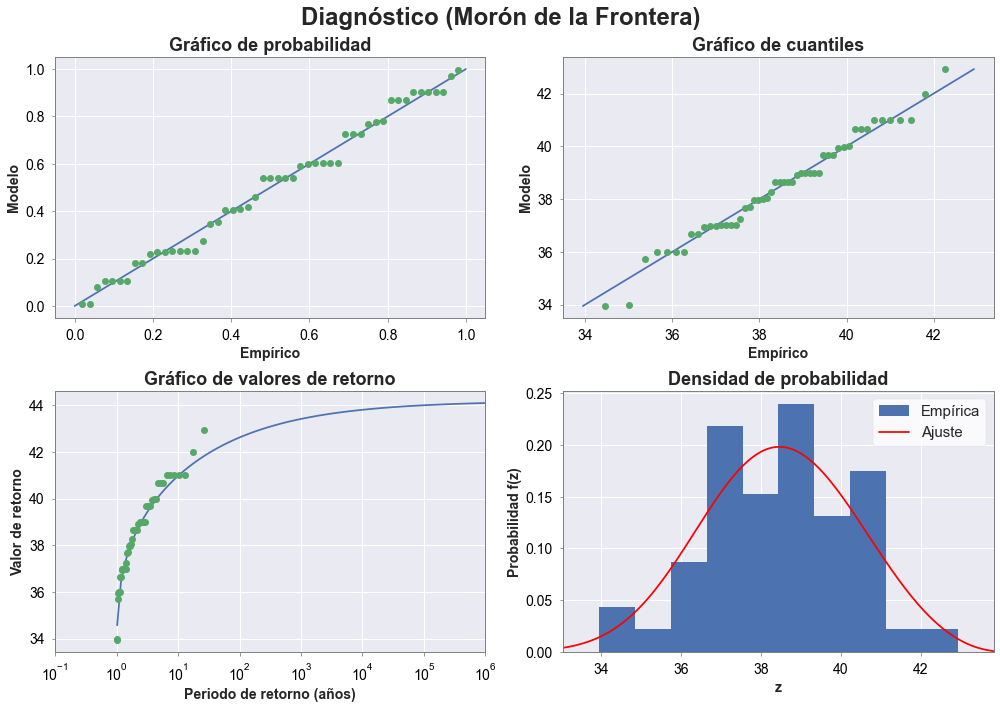

In [699]:
#Ajuste usando herramienta de scipy:
x = moron.copy()
c, m, s = stats.genextreme.fit(x)
c = - c
fig, ax = diagnosticsGEV(x,c,m,s)
text = fig.suptitle('Diagnóstico (Morón de la Frontera)',weight='bold',fontsize=24)

In [701]:
val = 46

p = np.logspace(1, 9, 1000)
ret = returnLevel(1/p, c,m,s)
idx = (np.abs(ret - val)).argmin()
print('El valor %.1f ºC tendría un periodo de retorno de unos %.0e años.'%(val,p[idx]))

El valor 46.0 ºC tendría un periodo de retorno de unos 1e+09 años.


Para Morón no se llega a alcanzar siquiera aunque extrapolemos.

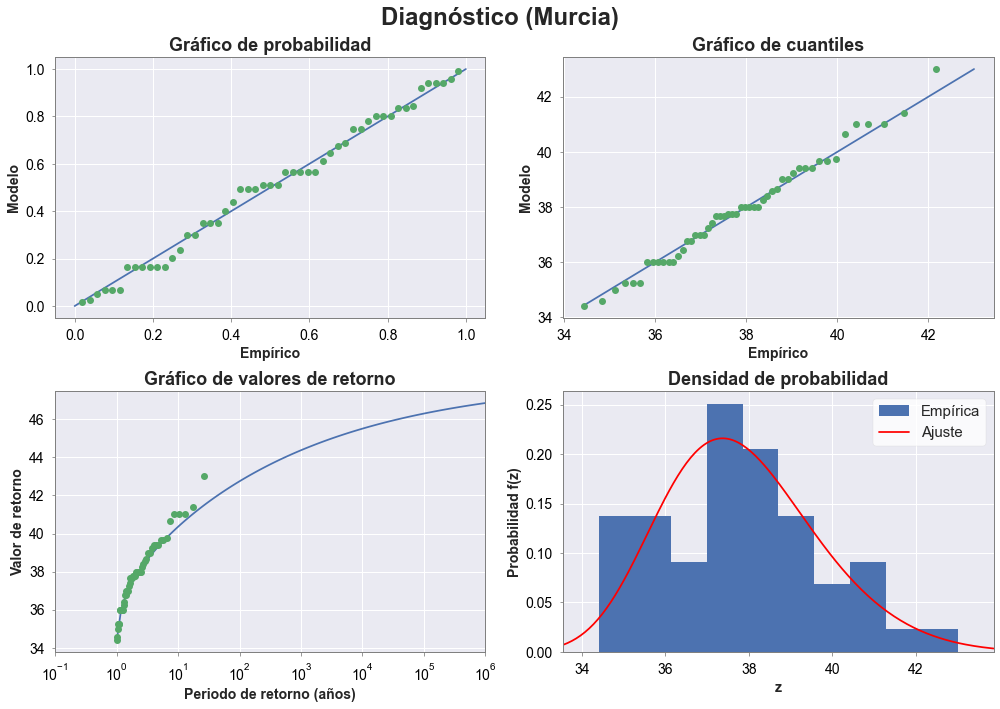

In [693]:
#Ajuste usando herramienta de scipy:
x = murcia.copy()
c, m, s = stats.genextreme.fit(x)
c = - c
fig, ax = diagnosticsGEV(x,c,m,s)
text = fig.suptitle('Diagnóstico (Murcia)',weight='bold',fontsize=24)

In [694]:
val = 45.1

p = np.logspace(1, 8, 1000)
ret = returnLevel(1/p, c,m,s)
idx = (np.abs(ret - val)).argmin()
print('El valor %.1f ºC tendría un periodo de retorno de %.0e años.'%(val,p[idx]))

El valor 45.1 ºC tendría un periodo de retorno de 4e+03 años.


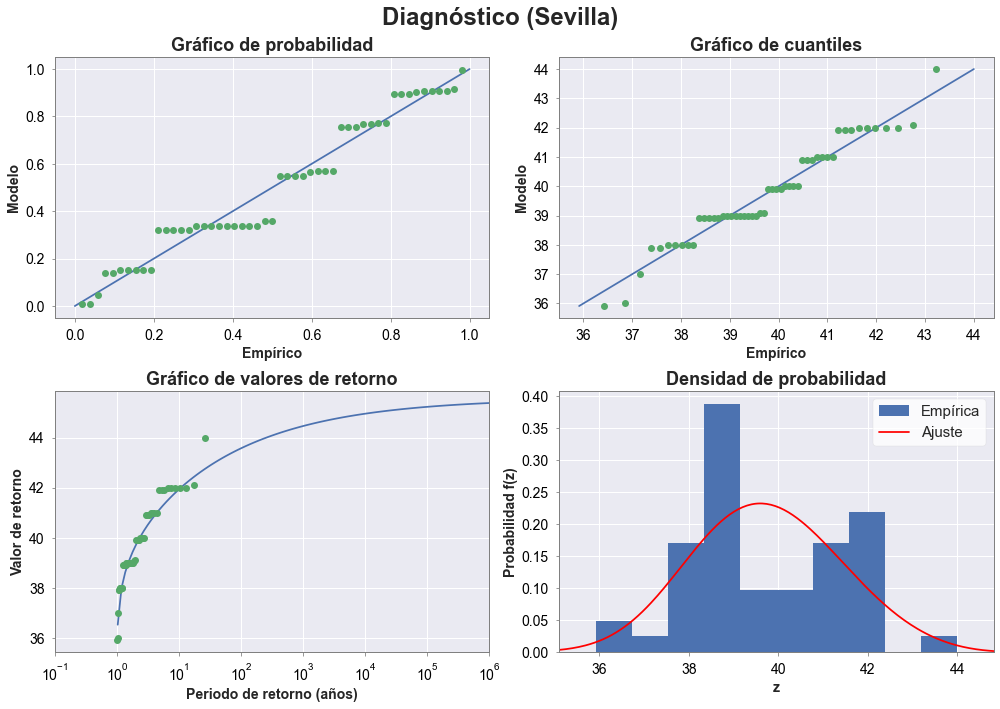

In [696]:
#Ajuste usando herramienta de scipy:
x = sevilla.copy()
c, m, s = stats.genextreme.fit(x)
c = - c
fig, ax = diagnosticsGEV(x,c,m,s)
text = fig.suptitle('Diagnóstico (Sevilla)',weight='bold',fontsize=24)

In [698]:
val = 44.8

p = np.logspace(1, 8, 1000)
ret = returnLevel(1/p, c,m,s)
idx = (np.abs(ret - val)).argmin()
print('El valor %.1f ºC tendría un periodo de retorno de %.0e años.'%(val,p[idx]))

El valor 44.8 ºC tendría un periodo de retorno de 4e+03 años.


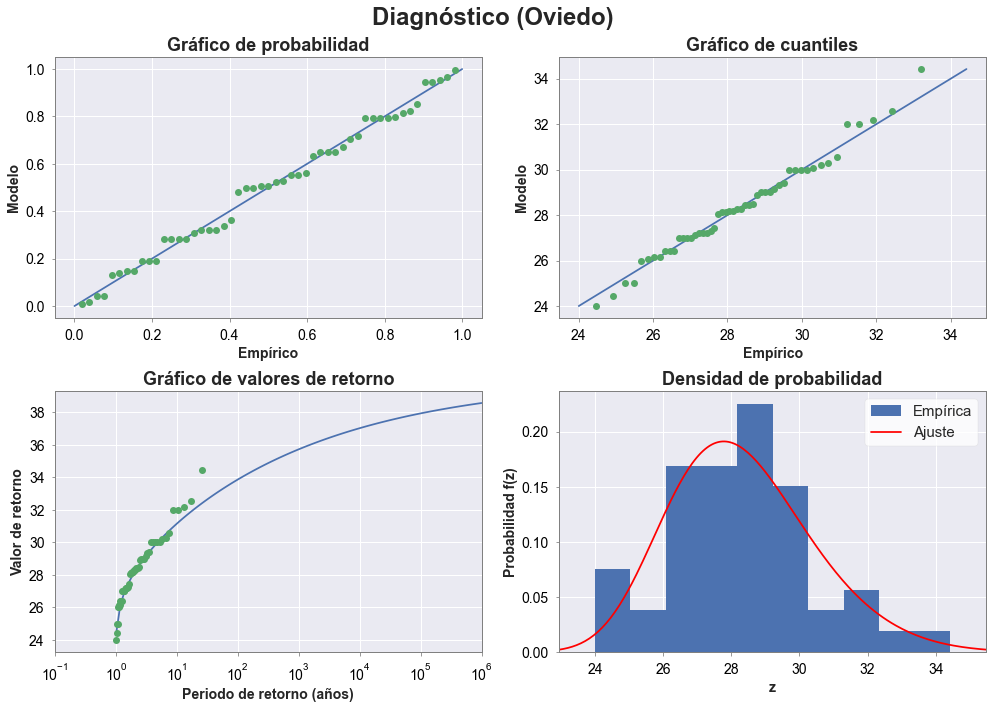

In [702]:
#Ajuste usando herramienta de scipy:
x = oviedo.copy()
c, m, s = stats.genextreme.fit(x)
c = - c
fig, ax = diagnosticsGEV(x,c,m,s)
text = fig.suptitle('Diagnóstico (Oviedo)',weight='bold',fontsize=24)

In [705]:
val = 39.1

p = np.logspace(1, 8, 1000)
ret = returnLevel(1/p, c,m,s)
idx = (np.abs(ret - val)).argmin()
print('El valor %.1f ºC tendría un periodo de retorno de unos %.0e años.'%(val,p[idx]))

El valor 39.1 ºC tendría un periodo de retorno de unos 2e+07 años.


---

# 3. Análisis Multivariante 

## Mapas de regresión del índice de presión con otros campos

Lo primero será leer los campos:

### SST

In [261]:
# SST
path2 = '../Practica 1/data/'
file_sst = 'HadISST1_sst_1870-2019.nc'
setSST = xr.open_dataset(path2+file_sst)

sst = setSST.sst.sel(time=slice('1960','2010'))
sst

<xarray.DataArray 'sst' (time: 612, latitude: 180, longitude: 360)>
[39657600 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * latitude   (latitude) float32 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * time       (time) datetime64[ns] 1960-01-16T12:00:00 ... 2010-12-16T12:00:00
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

Lo haré para el Pacífico Ecuatorial y para el Atlántico Norte/Mediterráneo

In [262]:
# Selecciono las regiones
sst_pa, lat_pa, lon_pa = region3(sst, sst.latitude, sst.longitude,-270, -70, -20, 20)
sst_a, lat_a, lon_a = region3(sst, sst.latitude, sst.longitude,260-360, 400-360, 10, 75)

In [264]:
nyears = index_cov.size

In [265]:
# Reorganizo los datos para que estén en numero de años, numero de meses y espacio
SST_A=np.reshape(np.asarray(sst_a), (nyears,12,len(lon_a)*len(lat_a)))
SST_PA=np.reshape(np.asarray(sst_pa), (nyears,12,len(lon_pa)*len(lat_pa)))

#### Para el mismo mes de Julio

In [266]:
sst_pa7 = sst_pa.sel(time=sst_pa.time.dt.month==7)
sst_a7 = sst_a.sel(time=sst_a.time.dt.month==7)

In [267]:
# Selecciono la estación
SST_a_7, ny2=season(SST_A,6,6+1,nyears)
SST_pa_7, ny2=season(SST_PA,6,6+1,nyears)

# Anomalías y transposición a (nt, ns)
sst_a_7=anom2(np.transpose(SST_a_7),1,'pp').T
sst_pa_7=anom2(np.transpose(SST_pa_7),1,'pp').T
sst_pa_7.shape

(51, 4400)

In [268]:
# Quito los nan
y_a7 = quitonans(sst_a_7)
y_pa7 = quitonans(sst_pa_7)
y_pa7.shape

(51, 4119)

In [330]:
# Mapas de regresión 
cor_a7,Pvalue_a7,cor_sig_a7,reg_a7,reg_sig_a7=IndexRegrCorr(np.transpose(y_a7),index_cov_std,0.05,'MonteCarlo',100)
cor_pa7,Pvalue_pa7,cor_sig_pa7,reg_pa7,reg_sig_pa7=IndexRegrCorr(np.transpose(y_pa7),index_cov_std,0.05,'MonteCarlo',100)

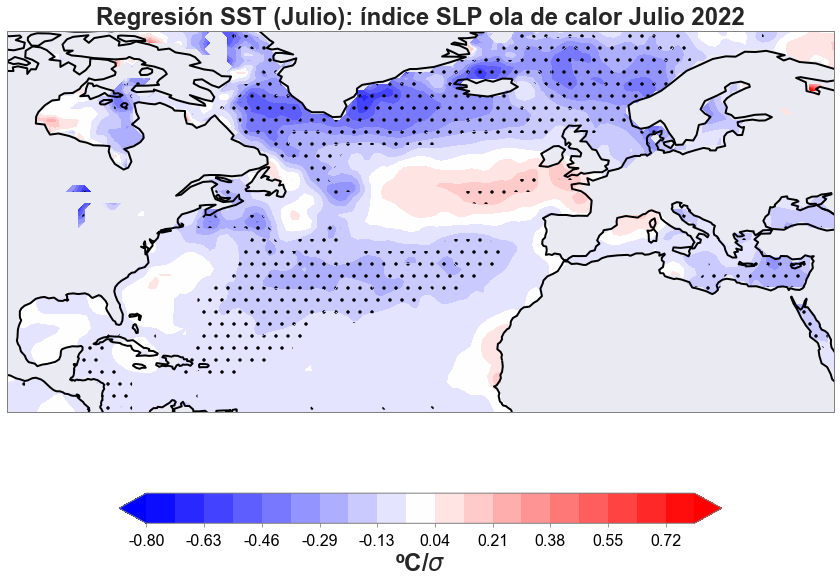

In [654]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))


var = pongonans(reg_a7,sst_a_7)
var_sig = pongonans(reg_sig_a7,sst_a_7)
rang = max((abs(np.nanmin(var)),abs(np.nanmax(var))))
rang = 0.8
levels = np.linspace(-rang,rang,20)

dibujo_1_mapa_cartopy(np.reshape(var,(lat_a.size,lon_a.size)),lon_a,lat_a,levels,'bwr',r'ºC/$\sigma$','Regresión SST (Julio): índice SLP ola de calor Julio 2022', ax)
ax.contourf(lon_a,lat_a,np.reshape(var_sig,(lat_a.size,lon_a.size)),cmap='bwr',levels=levels,hatches='.')

In [271]:
reg_sig_a7

masked_array(data=[--, --, --, ..., --, --, --],
             mask=[ True,  True,  True, ...,  True,  True,  True],
       fill_value=1e+20)

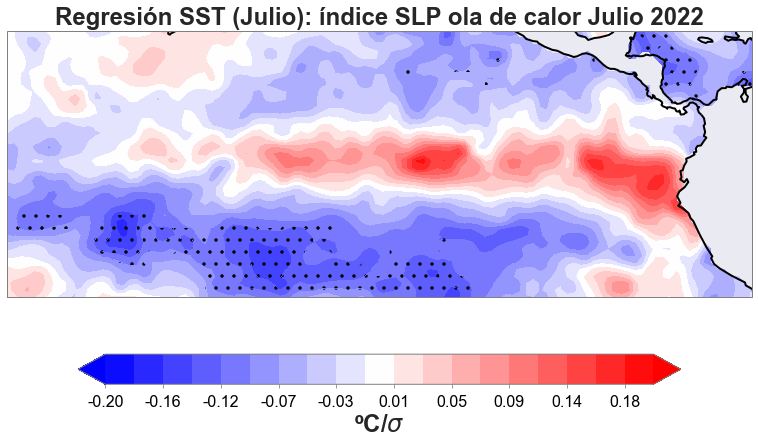

In [655]:
fig = plt.figure(figsize=(18,7),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))


var = pongonans(reg_pa7,sst_pa_7)
var_sig = pongonans(reg_sig_pa7,sst_pa_7)
rang = max((abs(np.nanmin(var)),abs(np.nanmax(var))))
rang = 0.2
levels = np.linspace(-rang,rang,20)

dibujo_1_mapa_cartopy(np.reshape(var,(lat_pa.size,lon_pa.size)),lon_pa,lat_pa,levels,'bwr',r'ºC/$\sigma$','Regresión SST (Julio): índice SLP ola de calor Julio 2022', ax)
ax.contourf(lon_pa,lat_pa,np.reshape(var_sig,(lat_pa.size,lon_pa.size)),cmap='bwr',levels=levels,hatches='.')

#### Con desfase: AMJ (los tres meses anteriores)

In [273]:
# Selecciono la estación
SST_a_amj, ny2=season(SST_A,3,5+1,nyears)
SST_pa_amj, ny2=season(SST_PA,3,5+1,nyears)

# Anomalías y transposición a (nt, ns)
sst_a_amj=anom2(np.transpose(SST_a_amj),1,'pp').T
sst_pa_amj=anom2(np.transpose(SST_pa_amj),1,'pp').T
sst_pa_amj.shape

(51, 4400)

In [274]:
# Quito los nan
y_a = quitonans(sst_a_amj)
y_pa = quitonans(sst_pa_amj)
y_pa.shape

(51, 4119)

In [275]:
# Mapas de regresión 
cor_a,Pvalue_a,cor_sig_a,reg_a,reg_sig_a=IndexRegrCorr(np.transpose(y_a),index_cov_std,0.05,'MonteCarlo',100)
cor_pa,Pvalue_pa,cor_sig_pa,reg_pa,reg_sig_pa=IndexRegrCorr(np.transpose(y_pa),index_cov_std,0.05,'MonteCarlo',100)

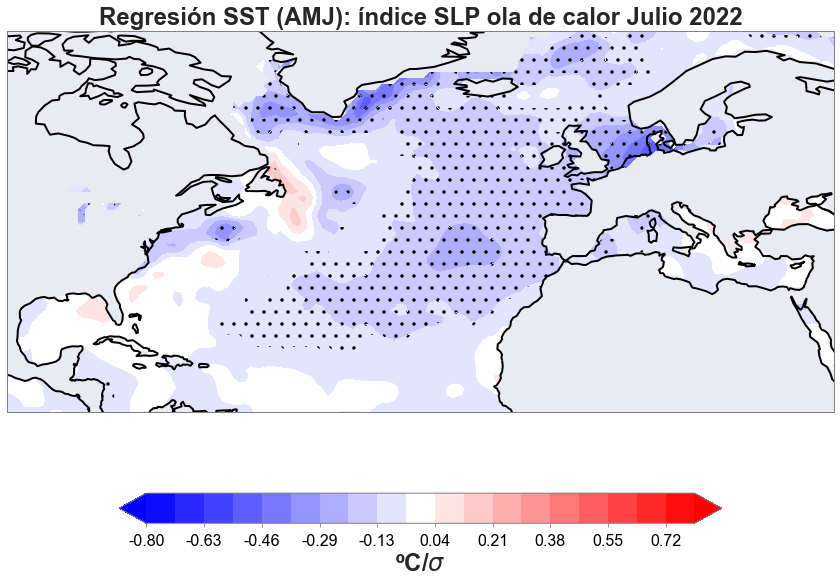

In [656]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))


var = pongonans(reg_a,sst_a_amj)
var_sig = pongonans(reg_sig_a,sst_a_amj)
rang = max((abs(np.nanmin(var)),abs(np.nanmax(var))))
rang = 0.8
levels = np.linspace(-rang,rang,20)

dibujo_1_mapa_cartopy(np.reshape(var,(lat_a.size,lon_a.size)),lon_a,lat_a,levels,'bwr',r'ºC/$\sigma$','Regresión SST (AMJ): índice SLP ola de calor Julio 2022', ax)
ax.contourf(lon_a,lat_a,np.reshape(var_sig,(lat_a.size,lon_a.size)),cmap='bwr',levels=levels,hatches='.')

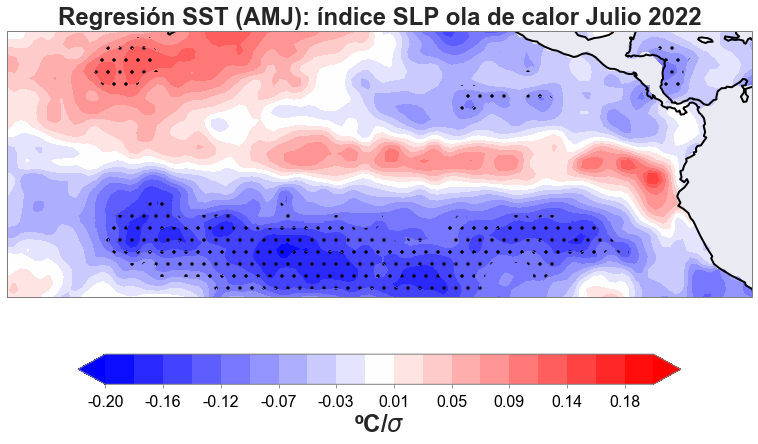

In [657]:
fig = plt.figure(figsize=(18,7),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))


var = pongonans(reg_pa,sst_pa_amj)
var_sig = pongonans(reg_sig_pa,sst_pa_amj)
rang = max((abs(np.nanmin(var)),abs(np.nanmax(var))))
rang = 0.2
levels = np.linspace(-rang,rang,20)

dibujo_1_mapa_cartopy(np.reshape(var,(lat_pa.size,lon_pa.size)),lon_pa,lat_pa,levels,'bwr',r'ºC/$\sigma$','Regresión SST (AMJ): índice SLP ola de calor Julio 2022', ax)
ax.contourf(lon_pa,lat_pa,np.reshape(var_sig,(lat_pa.size,lon_pa.size)),cmap='bwr',levels=levels,hatches='.')

=> Ante estos mapas no me queda clara ninguna conexión con la SST de estas dos regiones...

In [659]:
lat_g, lon_g = sst.latitude, sst.longitude
SST_g=np.reshape(np.asarray(sst), (nyears,12,len(lon_g)*len(lat_g)))
SST_g_7, ny2=season(SST_g,6,6+1,nyears)
sst_g_7=anom2(np.transpose(SST_g_7),1,'pp').T
y_g7 = quitonans(sst_g_7)

In [660]:
cor_g7,Pvalue_g7,cor_sig_g7,reg_g7,reg_sig_g7=IndexRegrCorr(np.transpose(y_g7),index_cov_std,0.05,'MonteCarlo',100)


c:\Users\digar7\anaconda3\envs\env1\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


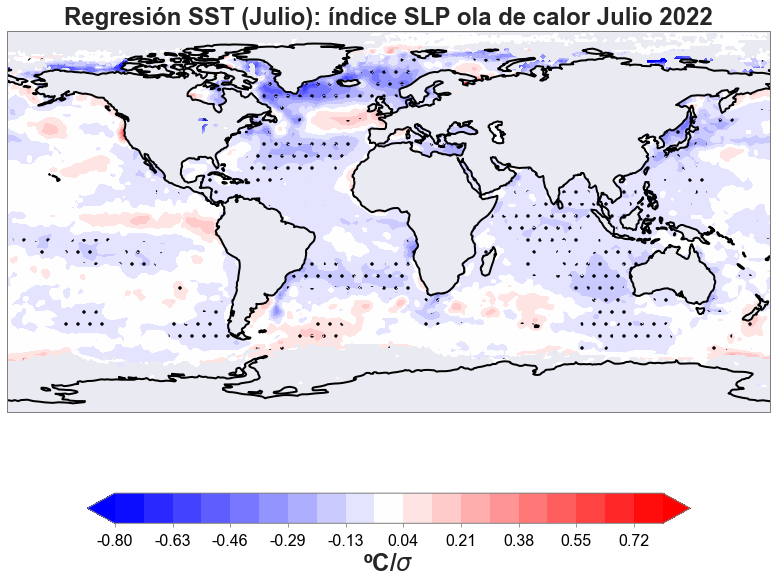

In [662]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))


var = pongonans(reg_g7,sst_g_7)
var_sig = pongonans(reg_sig_g7,sst_g_7)
rang = max((abs(np.nanmin(var)),abs(np.nanmax(var))))
rang = 0.8
levels = np.linspace(-rang,rang,20)

dibujo_1_mapa_cartopy(np.reshape(var,(lat_g.size,lon_g.size)),lon_g,lat_g,levels,'bwr',r'ºC/$\sigma$','Regresión SST (Julio): índice SLP ola de calor Julio 2022', ax)
ax.contourf(lon_g,lat_g,np.reshape(var_sig,(lat_g.size,lon_g.size)),cmap='bwr',levels=levels,hatches='.')

### SLP

Consideraré todo el planeta

In [279]:
# Ya tenía las anomalías para Julio calculadas de otro apartado
slp7

<xarray.DataArray 'msl' (time: 51, latitude: 181, longitude: 360)>
array([[[ 1.673523  ,  1.673523  ,  1.673523  , ...,  1.673523  ,
          1.673523  ,  1.673523  ],
        [ 1.3934937 ,  1.380249  ,  1.3682251 , ...,  1.434082  ,
          1.4212036 ,  1.4063721 ],
        [ 1.2484741 ,  1.2212524 ,  1.1956787 , ...,  1.3278198 ,
          1.3009033 ,  1.2757568 ],
        ...,
        [-1.9152832 , -1.9286499 , -1.9414062 , ..., -1.8782959 ,
         -1.8895874 , -1.9025879 ],
        [-1.932373  , -1.9384155 , -1.9442749 , ..., -1.9190063 ,
         -1.9230347 , -1.9283447 ],
        [-2.2370605 , -2.2370605 , -2.2370605 , ..., -2.2370605 ,
         -2.2370605 , -2.2370605 ]],

       [[ 0.0604248 ,  0.0604248 ,  0.0604248 , ...,  0.0604248 ,
          0.0604248 ,  0.0604248 ],
        [-0.394104  , -0.4058838 , -0.41931152, ..., -0.3505249 ,
         -0.36340332, -0.37835693],
        [-0.8312378 , -0.8584595 , -0.88397217, ..., -0.7503662 ,
         -0.7772827 , -0.8024292 ],
...
        [ 3.2235107 ,  3.220337  ,  3.2148438 , ...,  3.2372437 ,
          3.2332764 ,  3.227539  ],
        [ 2.2980957 ,  2.293518  ,  2.2877197 , ...,  2.2999268 ,
          2.298767  ,  2.2978516 ],
        [ 1.0153809 ,  1.0153809 ,  1.0153809 , ...,  1.0153809 ,
          1.0153809 ,  1.0153809 ]],

       [[-7.9312134 , -7.9312134 , -7.9312134 , ..., -7.9312134 ,
         -7.9312134 , -7.9312134 ],
        [-8.419128  , -8.417847  , -8.416748  , ..., -8.41626   ,
         -8.4175415 , -8.417847  ],
        [-8.809753  , -8.809387  , -8.811707  , ..., -8.805908  ,
         -8.806641  , -8.807129  ],
        ...,
        [-9.543579  , -9.5598755 , -9.574036  , ..., -9.499329  ,
         -9.514954  , -9.529358  ],
        [-9.687134  , -9.690308  , -9.693176  , ..., -9.692566  ,
         -9.689392  , -9.687378  ],
        [-9.978699  , -9.978699  , -9.978699  , ..., -9.978699  ,
         -9.978699  , -9.978699  ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 1960-07-01 1961-07-01 ... 2010-07-01

In [280]:
# Reshape
slp7_reshape = np.reshape(np.array(slp7),(slp7.time.size,slp7.longitude.size*slp7.latitude.size)).T

In [281]:
cor_slp,Pvalue_slp,cor_sig_slp,reg_slp,reg_sig_slp=IndexRegrCorr(slp7_reshape,index_cov_std,0.05,'MonteCarlo',100)

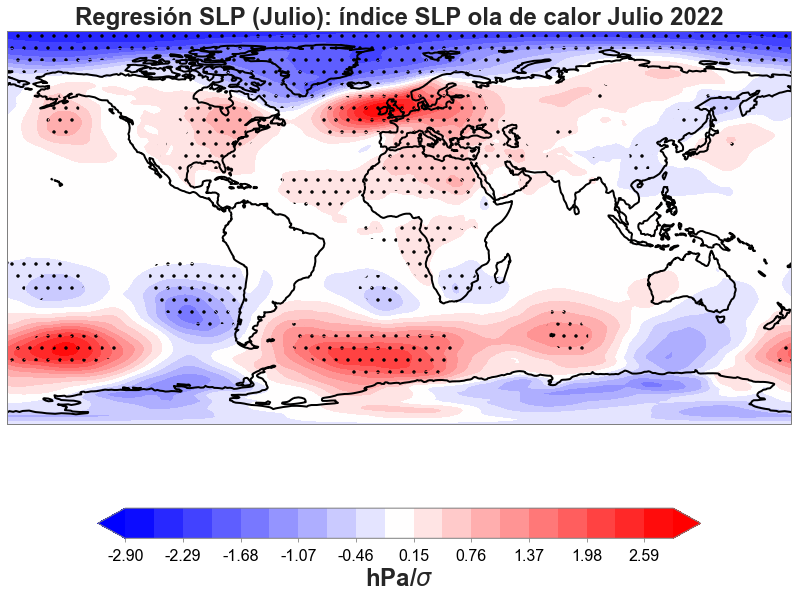

In [588]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))

var = reg_slp
var_sig = reg_sig_slp
rang = max((abs(var.min()),abs(var.max())))
levels = np.linspace(-rang,rang,20)

dibujo_1_mapa_cartopy(np.reshape(var,(slp.latitude.size,slp.longitude.size)),slp.longitude,slp.latitude,levels,'bwr',r'hPa/$\sigma$','Regresión SLP (Julio): índice SLP ola de calor Julio 2022', ax)
ax.contourf(slp.longitude,slp.latitude,np.reshape(var_sig,(slp.latitude.size,slp.longitude.size)),cmap='bwr',levels=levels,hatches='.')
plt.subplots_adjust(bottom=0.1)

=> Podemos observar el patrón que usamos para crear el propio índice pero también vemos otros patrones significativos en muchas partes del mundo, lo que da idea de conexiones a escala global.

> Se puede tratar de comparar con el mapa de 2022 para todo le mundo y no solo Europa.

## Relación del índice de presión con índices de extremos

### Índices $TX_x$ y $TN_x$

In [283]:
# Máxima de las máximas para el mes de Julio
txx = tmax7.groupby('time.year').max('time')
tnx = tmin7.groupby('time.year').max('time')

In [284]:
# Promedio en espacio y anomalía estándar  
index_txx = txx.mean(dim=['lat','lon'])
txx_std = (index_txx-index_txx.mean())/index_txx.std()

index_tnx = tnx.mean(dim=['lat','lon'])
tnx_std = (index_tnx-index_tnx.mean())/index_tnx.std()

(-3.5, 3.5)

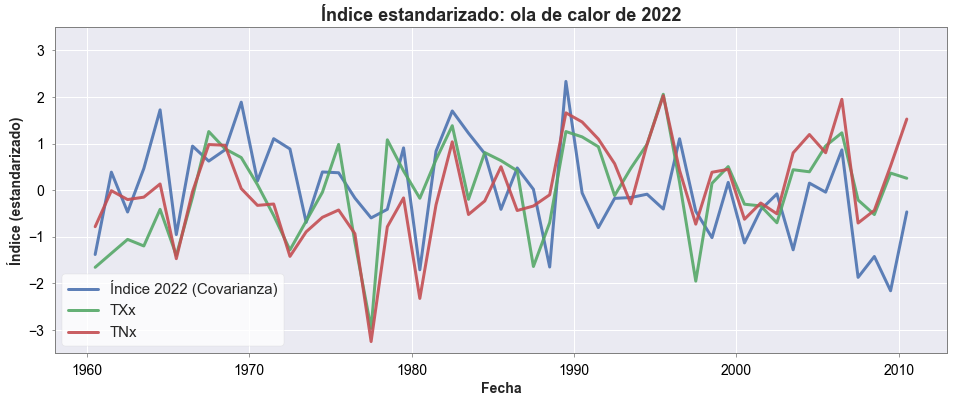

In [595]:
fig,ax = plt.subplots(figsize = (16,6))

ax.plot(index_regions_std.time,index_cov_std,linewidth=3,alpha=0.9,label='Índice 2022 (Covarianza)')
ax.plot(index_regions_std.time,txx_std,linewidth=3,alpha=0.9,label='TXx')
ax.plot(index_regions_std.time,tnx_std,linewidth=3,alpha=0.9,label='TNx')

ax.set_xlabel('Fecha')
ax.set_ylabel('Índice (estandarizado)')
ax.set_title('Índice estandarizado: ola de calor de 2022')
ax.legend() # Leyenda con título
ax.set_ylim(-3.5,3.5)


Text(0, 0.5, 'Índice TXx')

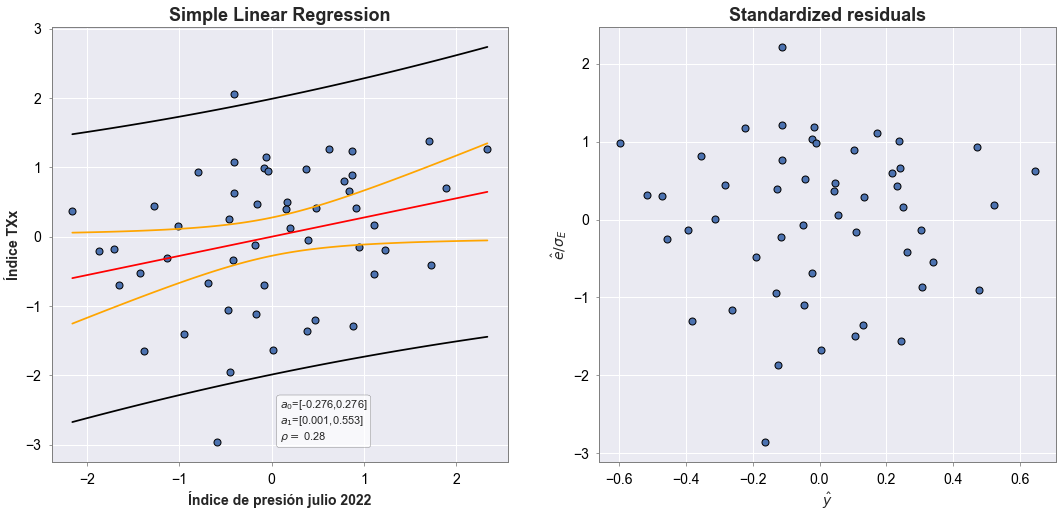

In [286]:
ax, a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(index_cov_std,txx_std)
ax[0].set_xlabel('Índice de presión julio 2022',size=14)
ax[0].set_ylabel('Índice TXx',size=14)

Text(0, 0.5, 'Índice TNx')

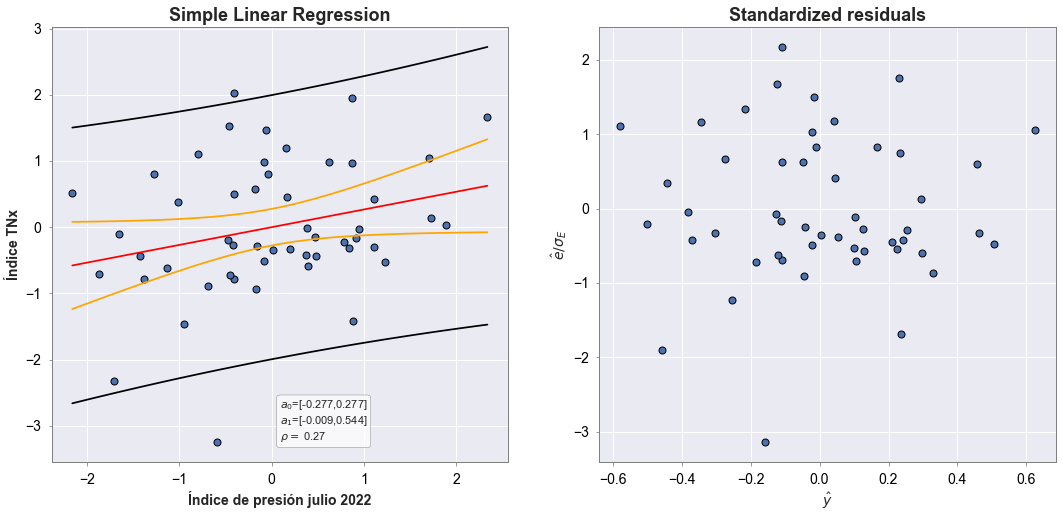

In [287]:
ax, a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(index_cov_std,tnx_std)
ax[0].set_xlabel('Índice de presión julio 2022',size=14)
ax[0].set_ylabel('Índice TNx',size=14)

Text(0, 0.5, 'Índice TNx')

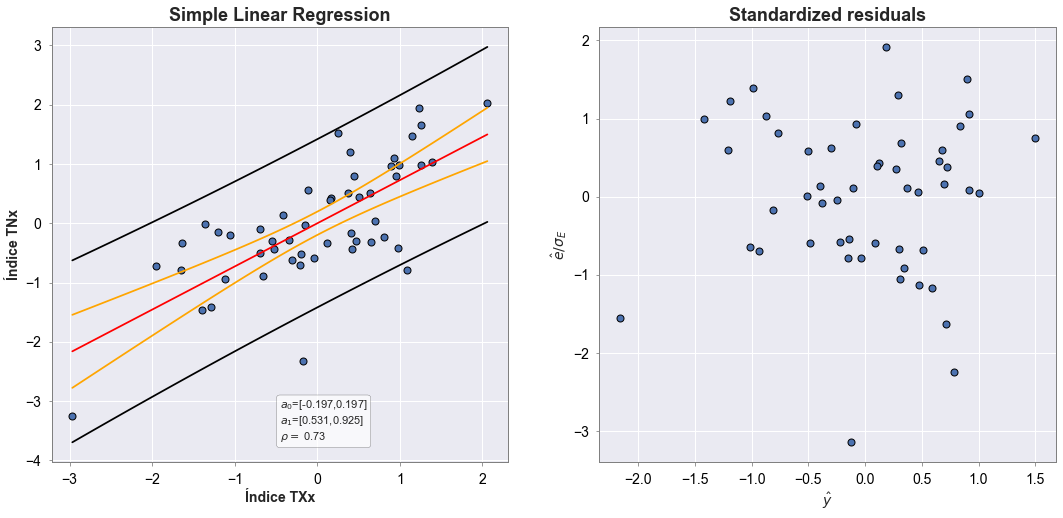

In [288]:
ax, a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(txx_std,tnx_std)
ax[0].set_xlabel('Índice TXx',size=14)
ax[0].set_ylabel('Índice TNx',size=14)

Mapas de regresión:

In [289]:
# Anomalía
txx_anom = txx-txx.mean('year')
tnx_anom = tnx-tnx.mean('year')

In [290]:
# Reshape y quitar nans
txx_ns = np.reshape(np.array(txx_anom),(txx_anom.year.size,txx_anom.lon.size*txx_anom.lat.size))
tnx_ns = np.reshape(np.array(tnx_anom),(tnx_anom.year.size,tnx_anom.lon.size*tnx_anom.lat.size))
y_txx = quitonans(txx_ns)
y_tnx = quitonans(tnx_ns)

In [291]:
cor_txx,Pvalue_txx,cor_sig_txx,reg_txx,reg_sig_txx=IndexRegrCorr(y_txx.T,index_cov_std,0.05,'MonteCarlo',100)
cor_tnx,Pvalue_tnx,cor_sig_tnx,reg_tnx,reg_sig_tnx=IndexRegrCorr(y_tnx.T,index_cov_std,0.05,'MonteCarlo',100)

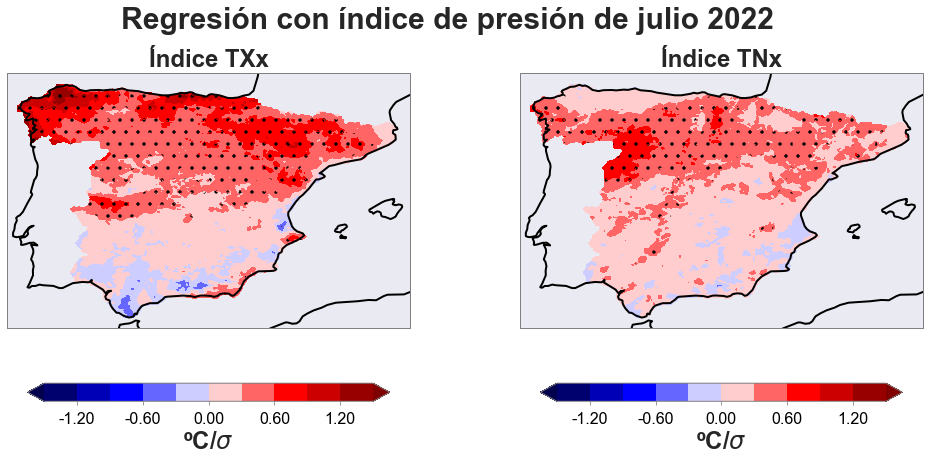

In [594]:
fig, (axu, axd) = plt.subplots(1,2,figsize=(20,7),facecolor='w', subplot_kw={'projection': ccrs.PlateCarree(0)}) 

var = pongonans(reg_txx,txx_ns)
var_sig = pongonans(reg_sig_txx,np.ma.array(txx_ns, mask=False))
rang = 1.5
step = 0.3
levels = np.arange(-rang,rang+step,step)
dibujo_1_mapa_cartopy(np.reshape(var,(lat.size,lon.size)),lon,lat,levels,'seismic',r'ºC/$\sigma$','Índice TXx', axu,res='50m')
axu.contourf(lon,lat,np.reshape(var_sig,(lat.size,lon.size)),cmap='seismic',levels=levels,hatches='.')

var = pongonans(reg_tnx,tnx_ns)
var_sig = pongonans(reg_sig_tnx,np.ma.array(tnx_ns, mask=False))
dibujo_1_mapa_cartopy(np.reshape(var,(lat.size,lon.size)),lon,lat,levels,'seismic',r'ºC/$\sigma$','Índice TNx', axd,res='50m')
axd.contourf(lon,lat,np.reshape(var_sig,(lat.size,lon.size)),cmap='seismic',levels=levels,hatches='.')
fig.suptitle(u'Regresión con índice de presión de julio 2022',size= 30, fontweight='bold')

plt.subplots_adjust(wspace=-0.15)
plt.subplots_adjust(top=0.85)

Observamos una mayor relación con anomalías en el norte peninsular. Podemos calcular el índice temporal solo para esa zona y ver en dicho caso como es la correlación. Lo haré solo para el caso de TXx que es donde observamos una señal más clara en el mapa de correlación:

In [293]:
norte_txx = txx.sel(lat=slice(44,40.5)).mean(dim=['lat','lon'])
sur_txx = txx.sel(lat=slice(40.5,35.5)).mean(dim=['lat','lon'])
norte_txx_std = (norte_txx-norte_txx.mean())/norte_txx.std()
sur_txx_std = (sur_txx-sur_txx.mean())/sur_txx.std()

(-3.5, 3.5)

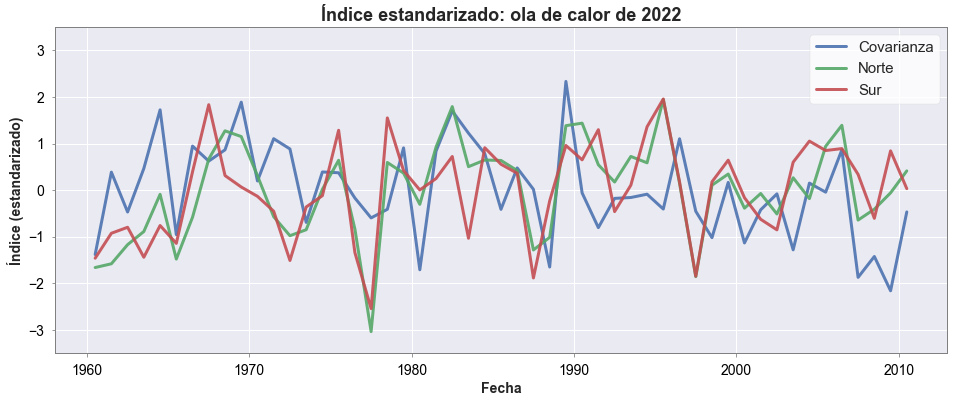

In [294]:
fig,ax = plt.subplots(figsize = (16,6))

ax.plot(index_regions_std.time,index_cov_std,linewidth=3,alpha=0.9,label='Covarianza')
ax.plot(index_regions_std.time,norte_txx_std,linewidth=3,alpha=0.9,label='Norte')
ax.plot(index_regions_std.time,sur_txx_std,linewidth=3,alpha=0.9,label='Sur')

ax.set_xlabel('Fecha')
ax.set_ylabel('Índice (estandarizado)')
ax.set_title('Índice estandarizado: ola de calor de 2022')
ax.legend() # Leyenda con título
ax.set_ylim(-3.5,3.5)

In [295]:
print('Correlación entre el índice 2022 y TXx (Norte): '+str(np.round(pearsonr(index_cov_std,norte_txx_std)[0],3)))
print('Correlación entre el índice 2022 y TXx (Sur):   '+str(np.round(pearsonr(index_cov_std,sur_txx_std)[0],3)))
print('Correlación entre el TXx (Norte) y TXx (Sur):   '+str(np.round(pearsonr(norte_txx_std,sur_txx_std)[0],3)))

Correlación entre el índice 2022 y TXx (Norte): 0.4
Correlación entre el índice 2022 y TXx (Sur):   0.095
Correlación entre el TXx (Norte) y TXx (Sur):   0.797


> Si que hay más correlación con el norte pero sigue siendo bastante baja. 

### Índice de Noches Tropicales

Cuenta del número de días que la mínima supera los 20ºC en el mes de interés.

In [296]:
trop_bool = xr.where(tmin7>20,1,0)
trop_bool = xr.where(np.isnan(tmin7),np.nan,trop_bool)

In [297]:
trop7 = trop_bool.groupby('time.year').sum('time')
trop7 = xr.where(np.isnan(txx),np.nan,trop7)

Mapa de regresión:

In [298]:
trop7_anom = trop7-trop7.mean('year')
trop_ns = np.reshape(np.array(trop7_anom),(trop7_anom.year.size,trop7_anom.lon.size*trop7_anom.lat.size))
y_trop = quitonans(trop_ns)
cor_trop,Pvalue_trop,cor_sig_trop,reg_trop,reg_sig_trop=IndexRegrCorr(y_trop.T,index_cov_std,0.05,'MonteCarlo',100)


c:\Users\digar7\anaconda3\envs\env1\lib\site-packages\scipy\stats\stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\digar7\AppData\Local\Temp/ipykernel_28360/3208981407.py:6: RuntimeWarning: invalid value encountered in true_divide
  rho = upper / lower


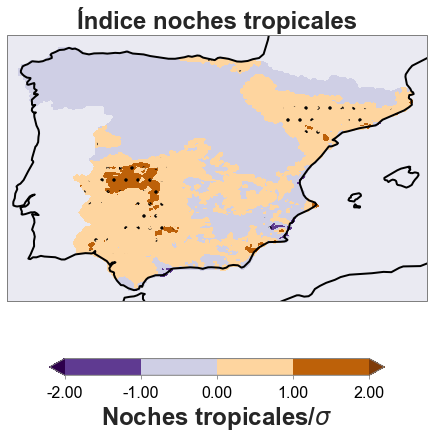

In [299]:
fig, (axu) = plt.subplots(1,1,figsize=(10,7),facecolor='w', subplot_kw={'projection': ccrs.PlateCarree(0)}) 

var = pongonans(reg_trop,trop_ns)
var_sig = pongonans(reg_sig_trop,np.ma.array(trop_ns, mask=False))
rang = 2
step = 1
levels = np.arange(-rang,rang+step,step)
dibujo_1_mapa_cartopy(np.reshape(var,(lat.size,lon.size)),lon,lat,levels,'PuOr_r',r'Noches tropicales/$\sigma$','Índice noches tropicales', axu,res='50m')
axu.contourf(lon,lat,np.reshape(var_sig,(lat.size,lon.size)),cmap='PuOr_r',levels=levels,hatches='.')


### Anomalías de la máximas y las mínimas y la precipitación

In [300]:
# Máxima de las máximas para el mes de Julio
txm = tmax7.groupby('time.year').mean('time')
tnm = tmin7.groupby('time.year').mean('time')

In [505]:
# Promedio en espacio y anomalía estándar  
index_txm = txm.mean(dim=['lat','lon'])
txm_std = (index_txm-index_txm.mean())/index_txm.std()

index_tnm = tnm.mean(dim=['lat','lon'])
tnm_std = (index_tnm-index_tnm.mean())/index_tnm.std()

index_pcp = pcp7xr.mean(dim=['lat','lon'])
pcp7_std = (index_pcp-index_pcp.mean())/index_pcp.std()

(-3.5, 3.5)

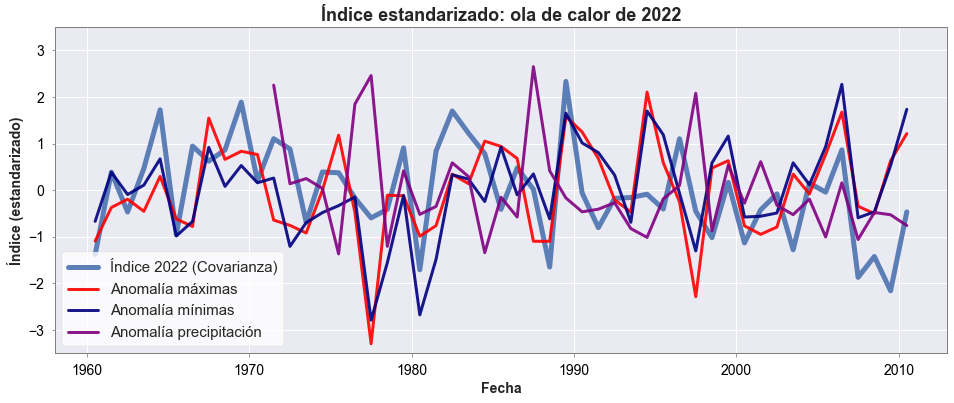

In [597]:
fig,ax = plt.subplots(figsize = (16,6))

ax.plot(index_regions_std.time,index_cov_std,linewidth=5,alpha=0.9,label='Índice 2022 (Covarianza)')
ax.plot(index_regions_std.time,txm_std,linewidth=3,alpha=0.9,label='Anomalía máximas',color='r')
ax.plot(index_regions_std.time,tnm_std,linewidth=3,alpha=0.9,label='Anomalía mínimas',color='navy')
ax.plot(index_regions_std.time[11:],pcp7_std,linewidth=3,alpha=0.9,label='Anomalía precipitación',color='purple')


ax.set_xlabel('Fecha')
ax.set_ylabel('Índice (estandarizado)')
ax.set_title('Índice estandarizado: ola de calor de 2022')
ax.legend() # Leyenda con título
ax.set_ylim(-3.5,3.5)


In [303]:
# Anomalía
txm_anom = txm-txm.mean('year')
tnm_anom = tnm-tnm.mean('year')

In [304]:
# Reshape y quitar nans
txm_ns = np.reshape(np.array(txm_anom),(txm_anom.year.size,txm_anom.lon.size*txm_anom.lat.size))
tnm_ns = np.reshape(np.array(tnm_anom),(tnm_anom.year.size,tnm_anom.lon.size*tnm_anom.lat.size))
y_txm = quitonans(txm_ns)
y_tnm = quitonans(tnm_ns)

In [305]:
cor_txm,Pvalue_txm,cor_sig_txm,reg_txm,reg_sig_txm=IndexRegrCorr(y_txm.T,index_cov_std,0.05,'MonteCarlo',100)
cor_tnm,Pvalue_tnm,cor_sig_tnm,reg_tnm,reg_sig_tnm=IndexRegrCorr(y_tnm.T,index_cov_std,0.05,'MonteCarlo',100)

In [509]:
# Precipitación
pcp_anom=pcp7xr-pcp7xr.std('time')
pcp_ns = np.reshape(np.array(pcp_anom),(pcp_anom.time.size,pcp_anom.lon.size*pcp_anom.lat.size))
y_pcp = quitonans(pcp_ns)
cor_pcp,Pvalue_pcp,cor_sig_pcp,reg_pcp,reg_sig_pcp=IndexRegrCorr(y_pcp.T,index_cov_std[11:],0.05,'MonteCarlo',100)

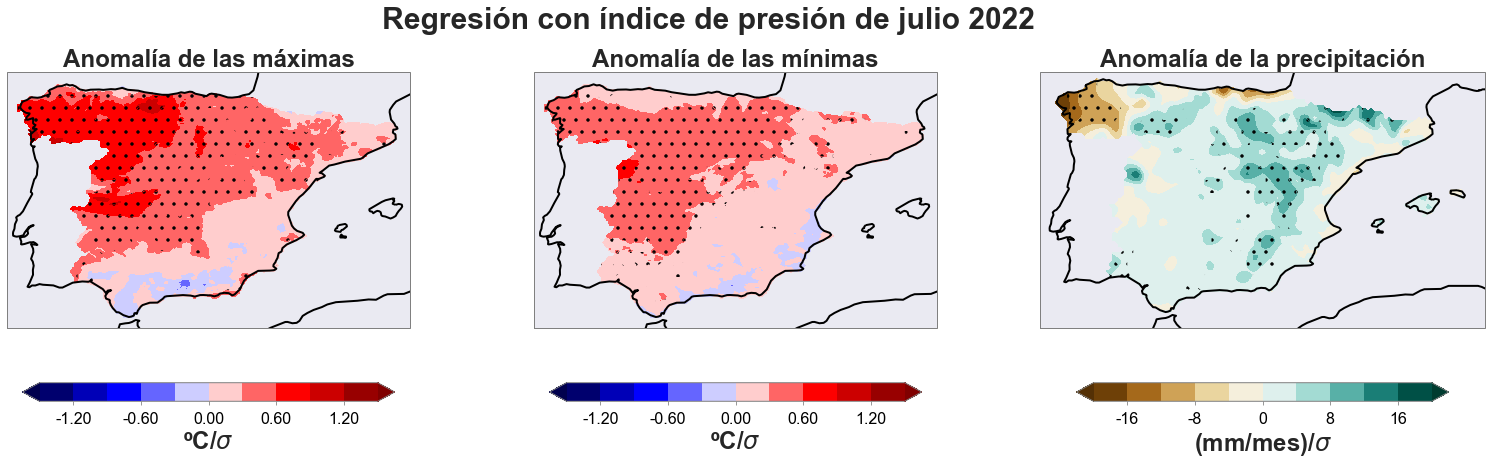

In [512]:
fig, (axu, axd, ax3) = plt.subplots(1,3,figsize=(30,7),facecolor='w', subplot_kw={'projection': ccrs.PlateCarree(0)}) 

var = pongonans(reg_txm,txm_ns)
var_sig = pongonans(reg_sig_txm,np.ma.array(txm_ns, mask=False))
rang = 1.5
step = 0.3
levels = np.arange(-rang,rang+step,step)
dibujo_1_mapa_cartopy(np.reshape(var,(lat.size,lon.size)),lon,lat,levels,'seismic',r'ºC/$\sigma$','Anomalía de las máximas', axu,res='50m')
axu.contourf(lon,lat,np.reshape(var_sig,(lat.size,lon.size)),cmap='seismic',levels=levels,hatches='.')

var = pongonans(reg_tnm,tnm_ns)
var_sig = pongonans(reg_sig_tnm,np.ma.array(tnm_ns, mask=False))
dibujo_1_mapa_cartopy(np.reshape(var,(lat.size,lon.size)),lon,lat,levels,'seismic',r'ºC/$\sigma$','Anomalía de las mínimas', axd,res='50m')
axd.contourf(lon,lat,np.reshape(var_sig,(lat.size,lon.size)),cmap='seismic',levels=levels,hatches='.')

var = pongonans(reg_pcp,pcp_ns)
var_sig = pongonans(reg_sig_pcp,np.ma.array(pcp_ns, mask=False))
rang = 20
step = 4
levels = np.arange(-rang,rang+step,step)
dibujo_1_mapa_cartopy(np.reshape(var,(lat_pcp.size,lon_pcp.size)),lon_pcp,lat_pcp,levels,'BrBG',r'(mm/mes)/$\sigma$','Anomalía de la precipitación', ax3,res='50m',cformat="%i")
ax3.contourf(lon_pcp,lat_pcp,np.reshape(var_sig,(lat_pcp.size,lon_pcp.size)),cmap='BrBG',levels=levels,hatches='.')
fig.suptitle(u'Regresión con índice de presión de julio 2022',size= 30, fontweight='bold')
ax3.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())


plt.subplots_adjust(wspace=-0.15)
plt.subplots_adjust(top=0.85)

In [307]:
norte_txm = txm.sel(lat=slice(44,40.5)).mean(dim=['lat','lon'])
sur_txm = txm.sel(lat=slice(40.5,35.5)).mean(dim=['lat','lon'])
norte_txm_std = (norte_txm-norte_txm.mean())/norte_txm.std()
sur_txm_std = (sur_txm-sur_txm.mean())/sur_txm.std()

(-3.5, 3.5)

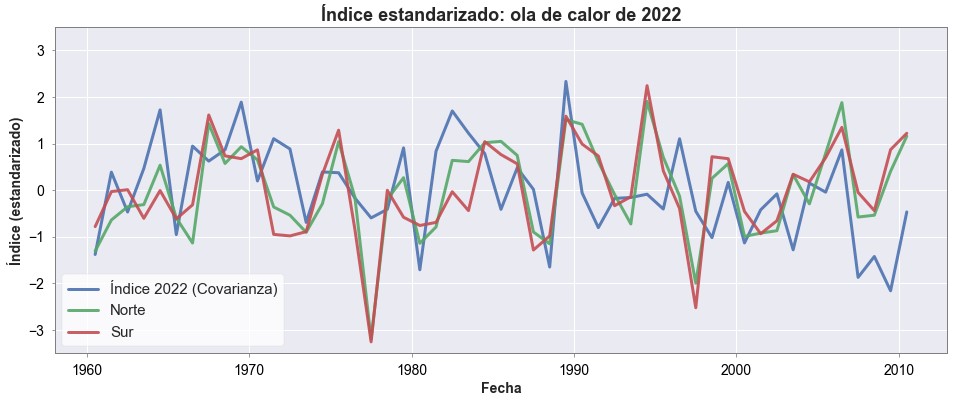

In [598]:
fig,ax = plt.subplots(figsize = (16,6))

ax.plot(index_regions_std.time,index_cov_std,linewidth=3,alpha=0.9,label='Índice 2022 (Covarianza)')
ax.plot(index_regions_std.time,norte_txm_std,linewidth=3,alpha=0.9,label='Norte')
ax.plot(index_regions_std.time,sur_txm_std,linewidth=3,alpha=0.9,label='Sur')

ax.set_xlabel('Fecha')
ax.set_ylabel('Índice (estandarizado)')
ax.set_title('Índice estandarizado: ola de calor de 2022')
ax.legend() # Leyenda con título
ax.set_ylim(-3.5,3.5)

In [309]:
print('Correlación entre el índice 2022 y TXx (Norte): '+str(np.round(pearsonr(index_cov_std,norte_txm_std)[0],3)))
print('Correlación entre el índice 2022 y TXx (Sur):   '+str(np.round(pearsonr(index_cov_std,sur_txm_std)[0],3)))
print('Correlación entre el TXx (Norte) y TXx (Sur):   '+str(np.round(pearsonr(norte_txx_std,sur_txm_std)[0],3)))

Correlación entre el índice 2022 y TXx (Norte): 0.385
Correlación entre el índice 2022 y TXx (Sur):   0.202
Correlación entre el TXx (Norte) y TXx (Sur):   0.737


## Análogos del evento de 2022 con otros años

Veamos alguno de los años que más valor tenía el índice:

In [310]:
years = np.arange(1960,2010+1)
year_max = years[np.argmax(index_cov_std)]
print(year_max)

1989


Represento la SLP de ese año:

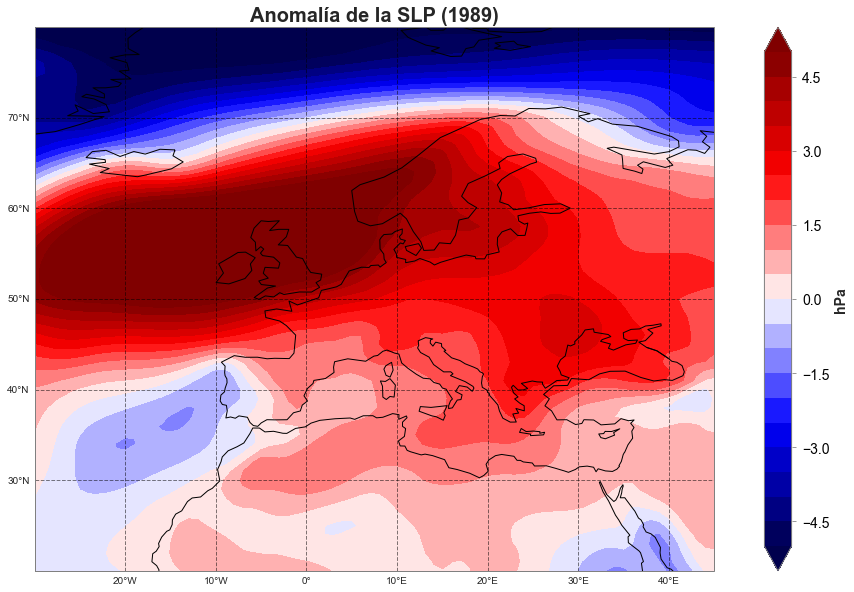

In [311]:
fig = plt.figure(figsize=(18,10),facecolor='w') 
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(0))

var = slp7_eu.sel(time=str(year_max)).squeeze()
rang = max((abs(var.min()),abs(var.max())))
step = 0.5
rang = 5
levels = np.arange(-rang,rang+step,step)

im = ax.contourf(var.longitude,var.latitude,var,levels,cmap='seismic',extend='both')
ax.coastlines(linewidth=1)
fig.colorbar(im,ax=ax,label='hPa')
ax.set_title('Anomalía de la SLP (%i)'%(year_max),size=20)
gl=ax.gridlines(draw_labels = True,color='k', alpha=0.5, linestyle='--')
gl.right_labels = False
gl.top_labels = False

El mapa es muy similar al de 2022, incluso con mayor intensidad del bloqueo sobre las Islas Británicas.

> Habrá que ver en los datos de SPAIN01 si fue o no un mes especialmente cálido.

Voy a calcular las anomalías de temperatura máxima y mínima para el mes de julio del año en cuestión con los datos STEAD

In [312]:
# Obtengo los promedios mensuales
tmax7_years = tmax7.groupby('time.year').mean('time')
tmin7_years = tmin7.groupby('time.year').mean('time')

In [313]:
# Lo paso a anomalías
tmax7_anom = tmax7_years-tmax7_years.mean('year')
tmin7_anom = tmin7_years-tmin7_years.mean('year')

Represento las anomalías:

Text(0.5, 0.98, 'Anomalías en julio de 1989')

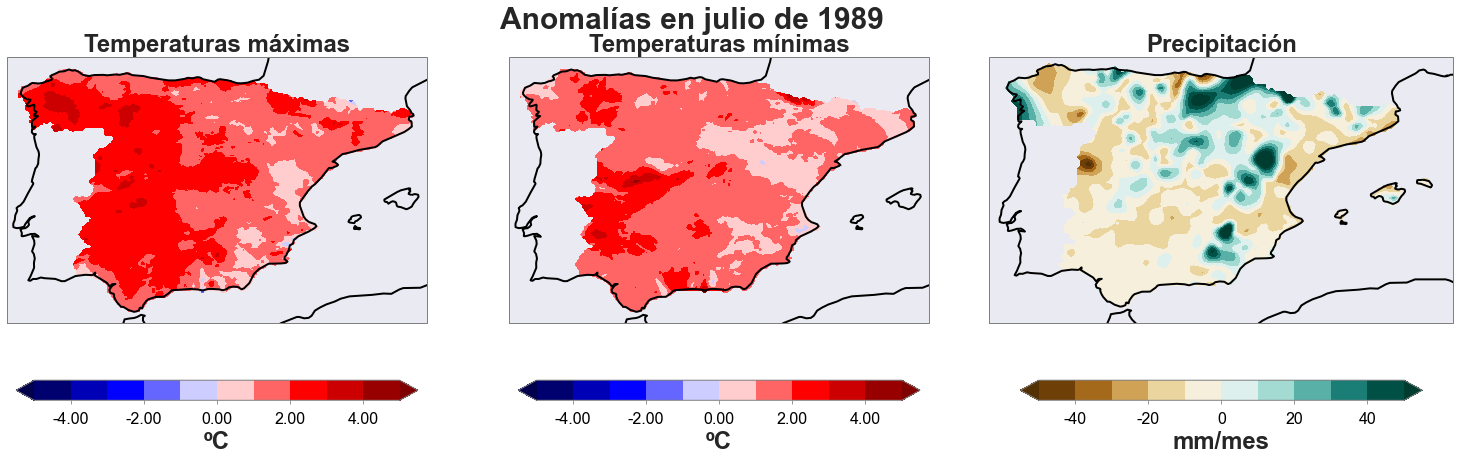

In [526]:
fig, (axu, axd, ax3) = plt.subplots(1,3,figsize=(30,7),facecolor='w', subplot_kw={'projection': ccrs.PlateCarree(0)}) 

var = tmax7_anom.sel(year=year_max).squeeze()
rang = 5
step = 1
levels = np.arange(-rang,rang+step,step)
dibujo_1_mapa_cartopy(var,var.lon,var.lat,levels,'seismic','ºC','Temperaturas máximas', axu, res='50m')


var = tmin7_anom.sel(year=year_max).squeeze()
dibujo_1_mapa_cartopy(var,var.lon,var.lat,levels,'seismic','ºC','Temperaturas mínimas', axd, res='50m')

var = pcp_anom.sel(time=str(year_max)).squeeze()
rang = 50
step = 10
levels = np.arange(-rang,rang+step,step)
dibujo_1_mapa_cartopy(var,lon_pcp,lat_pcp,levels,'BrBG','mm/mes','Precipitación', ax3, res='50m',cformat="%i")
ax3.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())


plt.subplots_adjust(wspace=-0.25)
fig.suptitle(u'Anomalías en julio de %i'%(year_max),size= 30, fontweight='bold')
#plt.tight_layout()

In [527]:
fig.savefig('anom_1989.png',dpi=150)

In [520]:
pcp_anom.sel(time=str(year_max)).squeeze().mean()

<xarray.DataArray 'pr' ()>
array(-1.3578343, dtype=float32)
Coordinates:
    time     datetime64[ns] 1989-07-31

Índices:

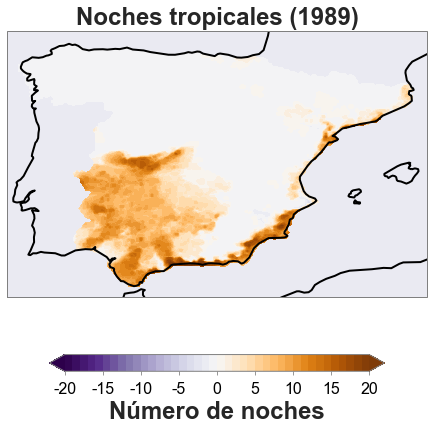

In [316]:
fig, (axu) = plt.subplots(1,1,figsize=(10,7),facecolor='w', subplot_kw={'projection': ccrs.PlateCarree(0)}) 

var = trop7_anom.sel(year=year_max).squeeze()- trop7_anom.mean('year')
rang = 20
step = 1
levels = np.arange(-rang,rang+step,step)
dibujo_1_mapa_cartopy(var,lon,lat,levels,'PuOr_r','Número de noches','Noches tropicales (%i)'%(year_max), axu,res='50m',cformat='%i')

## Análisis PCA y/o MCA

### EOFs de la SLP

Trataré de comparar con las PCs de la SLP para julio en la zona del Atlántico Norte (aunque ampliaré la zona hacia Europa que es para donde hemos tomado el índice del mapa de 2022):

In [317]:
# Región del mapa de 2022: longitude=slice(-30,45),latitude=slice(80,20)
slp7_ANeu = slp7.sel(longitude=slice(-100,45),latitude=slice(80,10))
slp7_ANeu = slp7_ANeu.interp(longitude=slp7_ANeu.longitude[::2]).interp(latitude=slp7_ANeu.latitude[::2])
slp7a_ANeu = slp7_ANeu-slp7_ANeu.mean('time')
lat_aneu = slp7a_ANeu.latitude
lon_aneu = slp7a_ANeu.longitude
[nt,nlat,nlon] = slp7a_ANeu.shape
slp7a_ANeu_ns = np.reshape(np.array(slp7a_ANeu),(nt,nlat*nlon))


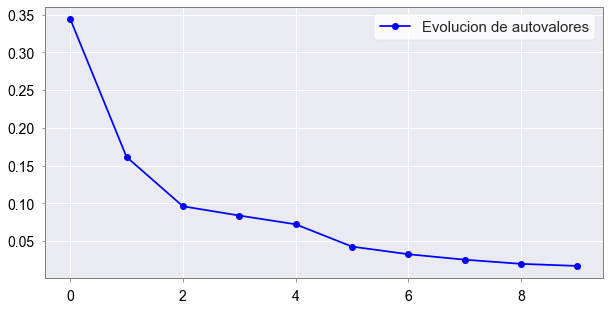

In [325]:
# Cálculo de las EOFs
C=np.dot(np.transpose(slp7a_ANeu_ns),slp7a_ANeu_ns)
eof,d,eof2=linalg.svd(C) # d es la matriz diagonal, eof son los autovectores
fvar=(d)/sum(d)


PC=np.dot(slp7a_ANeu_ns,eof[:,:3])
PCs=(PC-np.mean(PC))/np.std(PC)

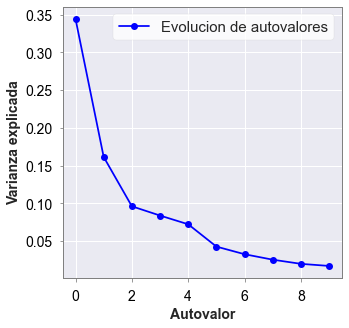

In [618]:
fig,ax = plt.subplots(figsize = (5,5))
plt.plot(fvar[:10],color='Blue',marker='o',label='Evolucion de autovalores')
plt.xlabel('Autovalor')
plt.ylabel('Varianza explicada')
plt.legend()

(-5.0, 5.0)

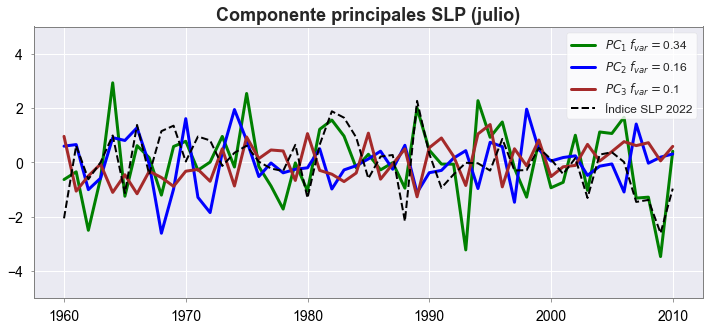

In [599]:
# Representación de las PCs
fig,ax=plt.subplots(figsize = (12,5))
ax.plot(years,PCs[:,0],linewidth= 3,color='green',label=r'$PC_1$ $f_{var}=$'+ str(round(fvar[0],2)))
ax.plot(years,PCs[:,1],linewidth= 3,color='b',label=r'$PC_2$ $f_{var}=$'+ str(round(fvar[1],2)))
ax.plot(years,PCs[:,2],linewidth= 3,color='brown',label=r'$PC_3$ $f_{var}=$'+ str(round(fvar[2],2)))
ax.plot(years,index_points_std,linewidth= 2,color='k',linestyle='--', label='Índice SLP 2022')


ax.legend(prop={'size':12})
ax.set_title('Componente principales SLP (julio)',fontsize=18,weight='bold')
ax.set_ylim(-5,5)

Vemos ya a ojo que el índice se parece bastante a la PC1.

In [320]:
# Mapas de las EOFs
cor1,Pvalue1,cor_sig1,reg1,reg1_sig=IndexRegression(np.transpose(slp7a_ANeu_ns),np.transpose(PCs[:,0]),0.05,'MonteCarlo',100)
cor2,Pvalue2,cor_sig2,reg2,reg2_sig=IndexRegression(np.transpose(slp7a_ANeu_ns),np.transpose(PCs[:,1]),0.05,'MonteCarlo',100)
cor3,Pvalue3,cor_sig3,reg3,reg3_sig=IndexRegression(np.transpose(slp7a_ANeu_ns),np.transpose(PCs[:,2]),0.05,'MonteCarlo',100)

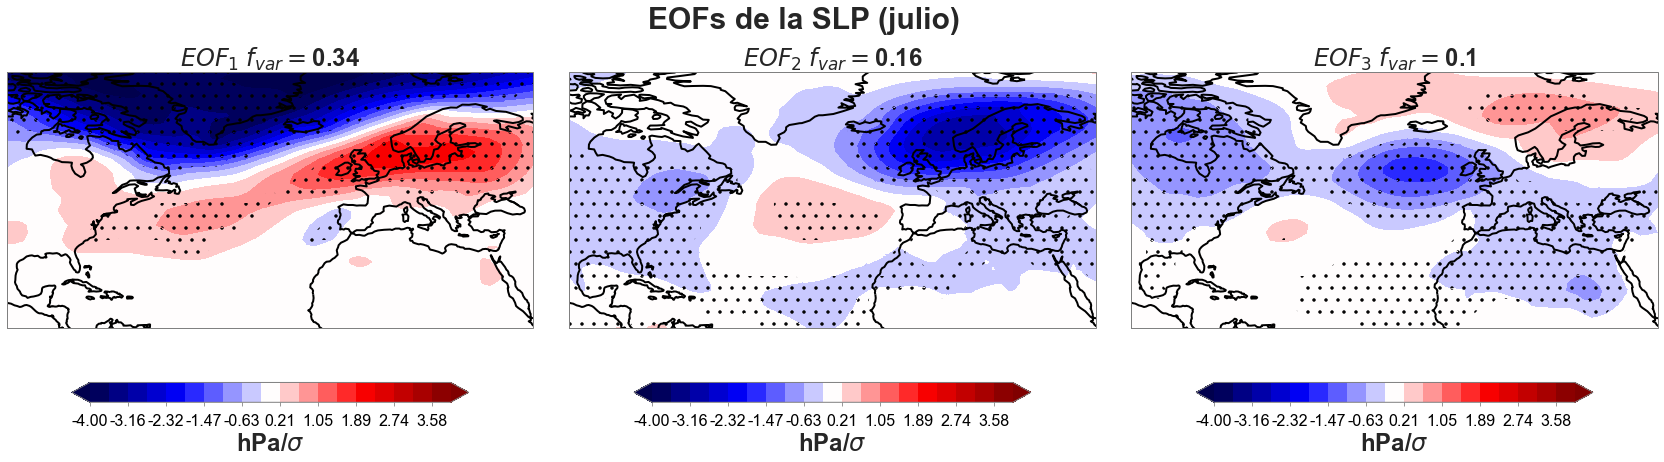

In [531]:
# Representación de los mapas de las EOFs
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(32,7),facecolor='w', subplot_kw={'projection': ccrs.PlateCarree(0)}) 
fig.suptitle(u'EOFs de la SLP (julio)',size= 30, fontweight='bold')


var = reg1
var_sig = reg1_sig
rang = 4
levels = np.linspace(-rang,rang,20)
dibujo_1_mapa_cartopy(np.reshape(var,(nlat,nlon)),lon_aneu,lat_aneu,levels,'seismic',r'hPa/$\sigma$',r'$EOF_1$ $f_{var}=$'+ str(round(fvar[0],2)), ax1)
ax1.contourf(lon_aneu,lat_aneu,np.reshape(var_sig,(nlat,nlon)),cmap='seismic',levels=levels,hatches='.')


var = reg2
var_sig = reg2_sig
dibujo_1_mapa_cartopy(np.reshape(var,(nlat,nlon)),lon_aneu,lat_aneu,levels,'seismic',r'hPa/$\sigma$',r'$EOF_2$ $f_{var}=$'+ str(round(fvar[1],2)), ax2)
ax2.contourf(lon_aneu,lat_aneu,np.reshape(var_sig,(nlat,nlon)),cmap='seismic',levels=levels,hatches='.')

var = reg3
var_sig = reg3_sig
dibujo_1_mapa_cartopy(np.reshape(var,(nlat,nlon)),lon_aneu,lat_aneu,levels,'seismic',r'hPa/$\sigma$',r'$EOF_3$ $f_{var}=$'+ str(round(fvar[2],2)), ax3)
ax3.contourf(lon_aneu,lat_aneu,np.reshape(var_sig,(nlat,nlon)),cmap='seismic',levels=levels,hatches='.')

plt.subplots_adjust(wspace=-0.15)
plt.subplots_adjust(top=0.85)

In [535]:
fig.savefig('eof_slp.png',dpi=150)

El mapa de la EOF1 tiene prácticamente el mismo patrón el que observamos en 2022 y con el que elaboramos el índice. 

Text(0, 0.5, 'PC1 SLP (julio)')

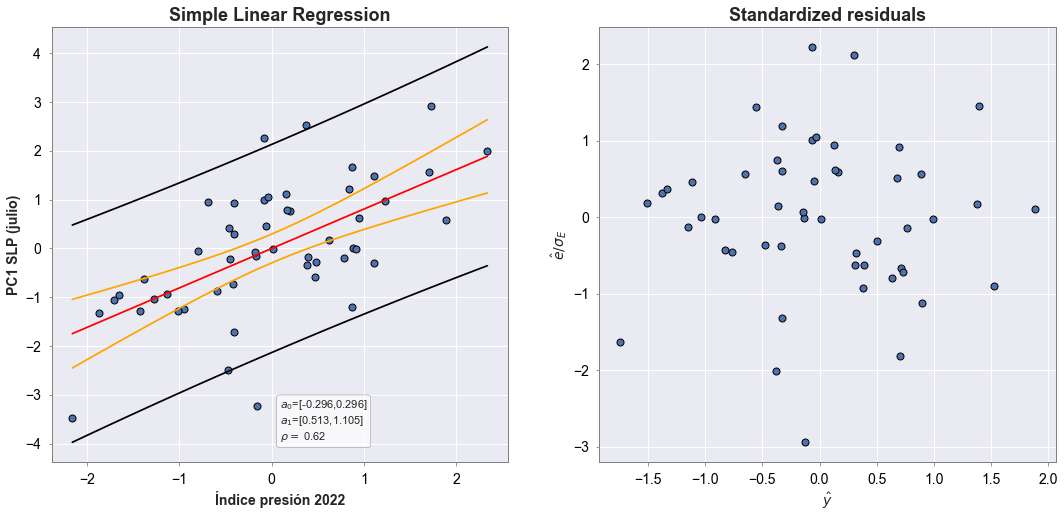

In [322]:
ax, a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(index_cov_std,PCs[:,0])
ax[0].set_xlabel('Índice presión 2022')
ax[0].set_ylabel('PC1 SLP (julio)')

La correlación es muy importante como ya se veía en los mapas y la gráfica conjunta de los índices. 

Text(0, 0.5, 'PC1 SLP (julio)')

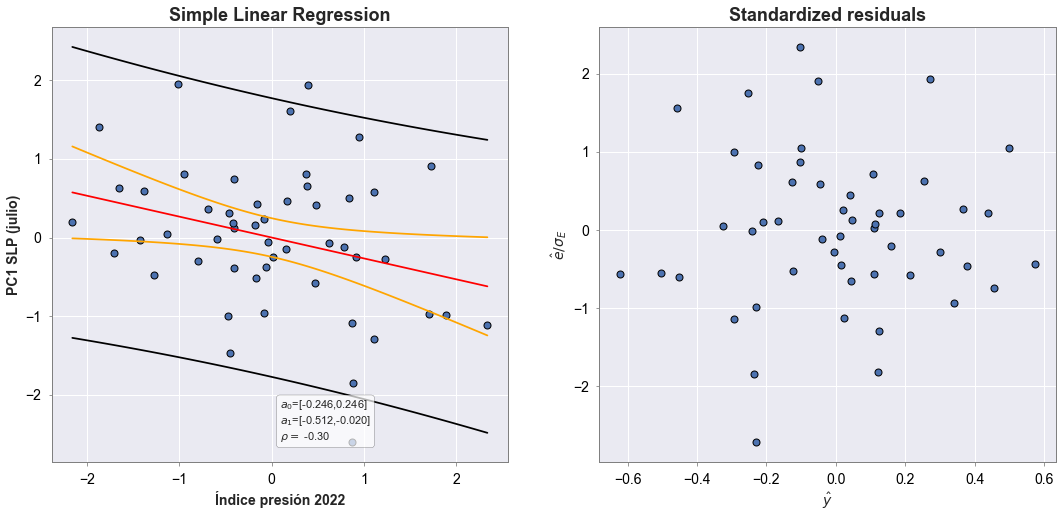

In [323]:
ax, a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(index_cov_std,PCs[:,1])
ax[0].set_xlabel('Índice presión 2022')
ax[0].set_ylabel('PC1 SLP (julio)')

Text(0, 0.5, 'PC1 SLP (julio)')

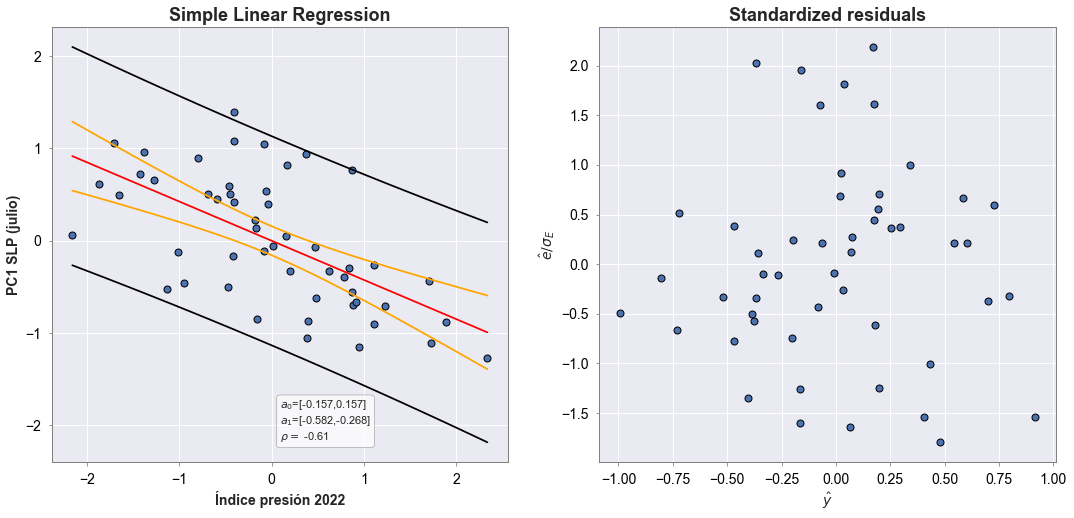

In [324]:
ax, a1, a0, rho, IC_a1, IC_a0, muY, AmuY, AY = regresLinSim(index_cov_std,PCs[:,2])
ax[0].set_xlabel('Índice presión 2022')
ax[0].set_ylabel('PC1 SLP (julio)')

---